## 1. Individual Maps

### 1.1 Cambridge

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from IPython.display import display, clear_output
import ipywidgets as widgets

# Crime data
# https://data.cambridgema.gov/Public-Safety/Crime-Reports/xuad-73uj/about_data
neighborhoods_crime_cambridge = pd.read_csv('Cambridge\\Crime_Reports_20250112.csv')
neighborhoods_crime_cambridge = neighborhoods_crime_cambridge[['Crime Date Time', 'Crime', 'Neighborhood', 'Reporting Area']].copy()
neighborhoods_crime_cambridge['Date'] = pd.to_datetime(neighborhoods_crime_cambridge['Crime Date Time'].str.split(' ').str[0])

# Population data from 2020 Census
# https://www.cambridgema.gov/-/media/Files/policedepartment/AnnualCrimeReports/2023AnnualCrimeReport_FINAL2.pdf
neighborhoods_pop_2020_cambridge = {
    "East Cambridge": 13246, "MIT": 6238, "Inman/Harrington": 6718,
    "Area 4": 7280, "Cambridgeport": 13083, "Mid-Cambridge": 13974,
    "Riverside": 12114, "Agassiz": 5146, "Peabody": 12471,
    "West Cambridge": 8450, "North Cambridge": 15372, "Highlands": 1646,
    "Strawberry Hill": 2665
}

# Geographical data
# https://www.cambridgema.gov/GIS/gisdatadictionary/Boundary/BOUNDARY_CDDNeighborhoods
shapefile_path_cambridge = 'Cambridge\\BOUNDARY_CDDNeighborhoods.shp'
geo_df_cambridge = gpd.read_file(shapefile_path_cambridge)
if geo_df_cambridge.crs != "EPSG:4326":
    geo_df_cambridge = geo_df_cambridge.to_crs(epsg=4326)

# Crime categories mapping
crime_macro_categories_cambridge = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime', 'Homicide': 'Violent Crime',
    'Kidnapping': 'Violent Crime', 'Simple Assault': 'Violent Crime',
    'Stalking': 'Violent Crime', 'Street Robbery': 'Violent Crime',
    'Threats': 'Violent Crime', 'Weapon Violations': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime', 'Auto Theft': 'Property Crime',
    'Commercial Break': 'Property Crime', 'Commercial Robbery': 'Property Crime',
    'Housebreak': 'Property Crime', 'Larceny (Misc)': 'Property Crime',
    'Larceny from Building': 'Property Crime', 'Larceny from MV': 'Property Crime',
    'Larceny from Person': 'Property Crime', 'Larceny from Residence': 'Property Crime',
    'Larceny of Bicycle': 'Property Crime', 'Larceny of Plate': 'Property Crime',
    'Larceny of Services': 'Property Crime', 'Mal. Dest. Property': 'Property Crime',
    'Shoplifting': 'Property Crime',

    # Drug Offenses
    'Drugs': 'Drug Offense',

    # White-Collar Crimes
    'Counterfeiting': 'White-Collar Crime', 'Embezzlement': 'White-Collar Crime',
    'Extortion/Blackmail': 'White-Collar Crime', 'Forgery': 'White-Collar Crime',
    'Flim Flam': 'White-Collar Crime',

    # Public Order Crimes
    'Annoying & Accosting': 'Public Order Crime', 'Disorderly': 'Public Order Crime',
    'Drinking in Public': 'Public Order Crime', 'Gambling': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime', 'Peeping & Spying': 'Public Order Crime',
    'Prostitution': 'Public Order Crime', 'Rec. Stol. Property': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',

    # Traffic Violations
    'Accident': 'Traffic Violation', 'Hit and Run': 'Traffic Violation',
    'Taxi Violation': 'Traffic Violation', 'OUI': 'Traffic Violation',

    # Personal Crimes
    'Domestic Dispute': 'Personal Crime', 'Harassment': 'Personal Crime',
    'Indecent Exposure': 'Personal Crime', 'Phone Calls': 'Personal Crime',
    'Sex Offender Violation': 'Personal Crime',

    # Protective Order Violations
    'Violation of H.O.': 'Protective Order Violation',
    'Violation of R.O.': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Admin Error': 'Administrative Issue',
    'Liquor Possession/Sale': 'Administrative Issue',
    'Missing Person': 'Miscellaneous',
    'Suspicious Package': 'Miscellaneous',
    'Warrant Arrest': 'Miscellaneous'
}

# Mapping dictionary for neighborhood names (for Geospatial df)
name_mapping_cambridge = {
    "The Port": "Area 4",
    "Neighborhood Nine": "Peabody",
    "Wellington-Harrington": "Inman/Harrington",
    "Mid-Cambridge": "Mid-Cambridge",
    "North Cambridge": "North Cambridge",
    "Cambridge Highlands": "Highlands",
    "Strawberry Hill": "Strawberry Hill",
    "West Cambridge": "West Cambridge",
    "Riverside": "Riverside",
    "Cambridgeport": "Cambridgeport",
    "Area 2/MIT": "MIT",
    "East Cambridge": "East Cambridge",
    "Baldwin": "Agassiz",
}

In [101]:
# Add macro crime categories
neighborhoods_crime_cambridge['Macro Crime'] = neighborhoods_crime_cambridge['Crime'].map(crime_macro_categories_cambridge)

# Map neighborhood names
geo_df_cambridge['Mapped_Name'] = geo_df_cambridge['NAME'].map(name_mapping_cambridge)

In [106]:
# Create widgets for interactive map
crime_dropdown = widgets.Dropdown(
    options=sorted(neighborhoods_crime_cambridge['Macro Crime'].unique()),
    value='Violent Crime',
    description='Crime:',
    style={'description_width': 'initial'}
)

start_date_picker = widgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime('2015-01-01'),
    style={'description_width': 'initial'}
)

end_date_picker = widgets.DatePicker(
    description='End Date:',
    value=pd.to_datetime('2025-01-07'),
    style={'description_width': 'initial'}
)

controls = widgets.HBox([crime_dropdown, start_date_picker, end_date_picker])

def render_map(selected_macro=None, start_date=None, end_date=None):
    clear_output(wait=True)
    
    # Filter data by date
    filtered_crime = neighborhoods_crime_cambridge[
        (neighborhoods_crime_cambridge['Date'] >= pd.to_datetime(start_date)) & 
        (neighborhoods_crime_cambridge['Date'] <= pd.to_datetime(end_date))
    ].copy()
    
    # Calculate crime rates
    crime_table_macro = filtered_crime.groupby(['Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
    rel_crime_table_macro = crime_table_macro.div(pd.Series(neighborhoods_pop_2020_cambridge), axis=0)
    
    # Create population DataFrame
    pop_df = pd.DataFrame.from_dict(neighborhoods_pop_2020_cambridge, orient='index', columns=['Population'])
    pop_df.index.name = 'Neighborhood'
    pop_df = pop_df.reset_index()

    # Merge data
    geo_df_selected = geo_df_cambridge.merge(
        rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
    )
    geo_df_selected = geo_df_selected.merge(
        pop_df, how='left', left_on='Mapped_Name', right_on='Neighborhood'
    )
    geo_df_selected[selected_macro] = geo_df_selected[selected_macro].round(5)

    # Create map
    geo_json = geo_df_selected.to_json()
    center_coords = geo_df_cambridge.geometry.centroid.y.mean(), geo_df_cambridge.geometry.centroid.x.mean()
    m = folium.Map(location=center_coords, zoom_start=13)

    # Add choropleth layer
    folium.Choropleth(
        geo_data=geo_json,
        data=geo_df_selected,
        columns=['Mapped_Name', selected_macro],
        key_on='feature.properties.Mapped_Name',
        fill_color='YlOrRd',
        fill_opacity=0.65,
        line_opacity=0.4,
        legend_name=f'Relative {selected_macro} Rate',
    ).add_to(m)

    # Add tooltip layer
    folium.GeoJson(
        geo_json,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['Mapped_Name', selected_macro, 'Population'],
            aliases=['Neighborhood:', f'{selected_macro} Score:', 'Population (2020):'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)
    
    display(controls)
    display(m)

def update_map(change=None):
    render_map(
        selected_macro=crime_dropdown.value,
        start_date=start_date_picker.value,
        end_date=end_date_picker.value
    )

# Link widgets to update function
crime_dropdown.observe(lambda change: update_map(change), names='value')
start_date_picker.observe(lambda change: update_map(change), names='value')
end_date_picker.observe(lambda change: update_map(change), names='value')

# Initial rendering
update_map()

C:\Users\nicco\AppData\Local\Temp\ipykernel_109788\1931989285.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df_cambridge.geometry.centroid.y.mean(), geo_df_cambridge.geometry.centroid.x.mean()


### 1.2 Boston

In [103]:
neighborhoods_crime_boston = pd.read_csv('Boston\\Boston_Incidents_View_3136327856209597499.csv')
neighborhoods_crime_boston = neighborhoods_crime_boston[['From Date', 'Crime', 'Neighborhood', 'BPD District']].copy()
neighborhoods_crime_boston['Date'] = pd.to_datetime(neighborhoods_crime_boston['From Date'].str.split(' ').str[0])
neighborhoods_crime_boston['Crime'] = neighborhoods_crime_boston['Crime'].str.title()

neighborhoods_pop_2019_boston = pd.read_excel('Boston\\2015-2019_neighborhood_tables_2021.12.21.xlsm', header=2)
neighborhoods_pop_2019_boston.set_index('Unnamed: 0', inplace=True)
neighborhoods_pop_2019_boston = neighborhoods_pop_2019_boston.loc['Allston':'West Roxbury', 'Total Population'].to_dict()
neighborhoods_pop_2019_boston = {k.strip(): v for k, v in neighborhoods_pop_2019_boston.items()}

shapefile_path_boston = 'Boston/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Block_Groups.shp'
geo_df_boston = gpd.read_file(shapefile_path_boston)
if geo_df_boston.crs != "EPSG:4326":
    geo_df_boston = geo_df_boston.to_crs(epsg=4326)

crime_macro_categories_boston = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime',
    'Homicide': 'Violent Crime',
    'Simple Assault': 'Violent Crime',
    'Indecent Assault': 'Violent Crime',
    'Robbery': 'Violent Crime',
    'Rape & Attempted': 'Violent Crime',
    'Threats To Do Bodily Harm': 'Violent Crime',
    'Murder, Non-Negligent Manslaughter': 'Violent Crime',
    'Assault - Simple': 'Violent Crime',
    'Assault - Aggravated': 'Violent Crime',
    'Sex Offense - Rape - Forcible': 'Violent Crime',
    'Sex Offense - Rape - Sodomy': 'Violent Crime',
    'Fondling - Indecent Assault': 'Violent Crime',
    'Human Trafficking': 'Violent Crime',
    'Manslaughter': 'Violent Crime',
    'Offenses Against Child / Family': 'Violent Crime',
    'Weapon Violation - Carry/ Possessing/ Sale/ Traffi': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime',
    'Auto Theft': 'Property Crime',
    'Auto Theft - Leased/Rented Vehicle': 'Property Crime',
    'Auto Theft - Motorcycle / Scooter': 'Property Crime',
    'Auto Theft Recovery': 'Property Crime',
    'Residential Burglary': 'Property Crime',
    'Commercial Burglary': 'Property Crime',
    'Burglary - Commerical': 'Property Crime',
    'Larceny From Mv': 'Property Crime',
    'Larceny Theft From Building': 'Property Crime',
    'Other Larceny': 'Property Crime',
    'Larceny Theft Of Bicycle': 'Property Crime',
    'Larceny Shoplifting': 'Property Crime',
    'Larceny Theft From Mv - Non-Accessory': 'Property Crime',
    'Larceny All Others': 'Property Crime',
    'Recovered Stolen Property': 'Property Crime',
    'Property Found': 'Property Crime',
    'Property Lost': 'Property Crime',
    'Vandalism': 'Property Crime',
    'Larceny Purse Snatch - No Force': 'Property Crime',
    'Breaking And Entering (B&E) Motor Vehicle (No Prop': 'Property Crime',
    'Recovered - Mv Recovered In Boston (Stolen In Bost': 'Property Crime',
    'Larceny Theft Of Mv Parts & Accessories': 'Property Crime',
    'Stolen Property - Buying / Receiving / Possessing': 'Property Crime',
    'Possession Of Burglarious Tools': 'Property Crime',
    'Property - Accidental Damage': 'Property Crime',
    'Property Related Damage': 'Property Crime',
    'Property - Found': 'Property Crime',
    'Property - Lost Then Located': 'Property Crime',
    'Property - Lost/ Missing': 'Property Crime',
    'License Plate Related Incidents': 'Property Crime',

    # Drug Offenses
    'Drug Violation': 'Drug Offense',
    'Drugs - Possession/ Sale/ Manufacturing/ Use': 'Drug Offense',
    'Drugs - Possession Of Drug Paraphanalia': 'Drug Offense',
    'Sick Assist - Drug Related Illness': 'Drug Offense',

    # White-Collar Crimes
    'Fraud': 'White-Collar Crime',
    'Counterfeiting': 'White-Collar Crime',
    'Embezzlement': 'White-Collar Crime',
    'Confidence Games': 'White-Collar Crime',
    'Forgery / Counterfeiting': 'White-Collar Crime',
    'Fraud - Credit Card / Atm Fraud': 'White-Collar Crime',
    'Fraud - False Pretense / Scheme': 'White-Collar Crime',
    'Fraud - Wire': 'White-Collar Crime',
    'Fraud - Welfare': 'White-Collar Crime',
    'Identity Fraud C266.37E': 'White-Collar Crime',

    # Public Order Crimes
    'Disorderly Conduct': 'Public Order Crime',
    'Prostitution': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',
    'Liquor Violation': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime',
    'Bomb Hoax': 'Public Order Crime',
    'Bomb Threat': 'Public Order Crime',
    'Gambling': 'Public Order Crime',
    'Dangerous Or Hazardous Condition': 'Public Order Crime',
    'Assembly Or Gathering Violations': 'Public Order Crime',
    'Disturbing The Peace/ Disorderly Conduct/ Gatherin': 'Public Order Crime',
    'Explosives': 'Public Order Crime',
    'Liquor Law Violation': 'Public Order Crime',
    'Noisy Party/Radio-No Arrest': 'Public Order Crime',
    'Violation - City Ordinance': 'Public Order Crime',

    # Traffic Violations
    'Mv Crash Response': 'Traffic Violation',
    'Operating Under The Influence': 'Traffic Violation',
    'M/V Accident - Personal Injury': 'Traffic Violation',
    'M/V Accident - Property Damage': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - Injury': 'Traffic Violation',
    'M/V Accident - Other': 'Traffic Violation',
    'M/V - Leaving Scene - Property Damage': 'Traffic Violation',
    'M/V - Leaving Scene - Personal Injury': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - No Injury': 'Traffic Violation',
    'M/V Accident - Other City Vehicle': 'Traffic Violation',
    'M/V Accident - Police Vehicle': 'Traffic Violation',
    'M/V Plates - Lost': 'Traffic Violation',
    'Towed Motor Vehicle': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - Injury': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - No Injury': 'Traffic Violation',
    'Towed': 'Traffic Violation',
    'Val - Operating After Rev/Susp.': 'Traffic Violation',
    'Val - Operating W/O Authorization Lawful': 'Traffic Violation',
    'Val - Violation Of Auto Law': 'Traffic Violation',
    'Operating Under The Influence (Oui) Alcohol': 'Traffic Violation',

    # Personal Crimes
    'Verbal Disputes': 'Personal Crime',
    'Verbal Dispute': 'Personal Crime',
    'Criminal Harassment': 'Personal Crime',
    'Harassment/ Criminal Harassment': 'Personal Crime',
    'Sex Offender Registration': 'Personal Crime',
    'Indecent Exposure/ Lewd And Lascivious/ Open And G': 'Personal Crime',
    'Child Endangerment': 'Personal Crime',
    'Failure To Register As A Sex Offender': 'Personal Crime',
    'Phone Call Complaints': 'Personal Crime',
    'Obscene Materials - Pornography': 'Personal Crime',
    'Sex Offense - Other': 'Personal Crime',
    'Sexual Assault Investigation': 'Personal Crime',
    'Sexual Assault Kit Collected': 'Personal Crime',

    # Protective Order Violations
    'Restraining Order Violations': 'Protective Order Violation',
    'Viol. Of Restraining Order W Arrest': 'Protective Order Violation',
    'Violation - Restraining Order (No Arrest)': 'Protective Order Violation',
    'Violation - Harassment Prevention Order': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Investigate Person': 'Miscellaneous',
    'Investigate Property': 'Miscellaneous',
    'Service': 'Miscellaneous',
    'Search Warrants': 'Miscellaneous',
    'Search Warrant': 'Miscellaneous',
    'Missing Person Reported': 'Miscellaneous',
    'Missing Person Located': 'Miscellaneous',
    'Missing Person - Located': 'Miscellaneous',
    'Missing Person - Not Reported - Located': 'Miscellaneous',
    'Fire Related Reports': 'Miscellaneous',
    'Fire Report': 'Miscellaneous',
    'Fire Report/Alarm - False': 'Miscellaneous',
    'Landlord/Tenant Disputes': 'Miscellaneous',
    'Landlord - Tenant': 'Miscellaneous',
    'Animal Incidents (Dog Bites, Lost Dog, Etc)': 'Miscellaneous',
    'Animal Abuse': 'Miscellaneous',
    'Death Investigation': 'Miscellaneous',
    'Prisoner Related Incidents': 'Miscellaneous',
    'Recovered - Mv Recovered In Boston (Stolen Outside': 'Miscellaneous',
    'Aircraft': 'Miscellaneous',
    'Evading Fare': 'Miscellaneous',
    'Biological Threat': 'Miscellaneous',
    'Sudden Death': 'Miscellaneous',
    'Fugitive From Justice': 'Miscellaneous',
    'Other': 'Miscellaneous',
    'Other Offense': 'Miscellaneous',
    'Ballistics': 'Miscellaneous',
    'Ballistics Evidence/Found': 'Miscellaneous',
    'Firearm Discovery': 'Miscellaneous',
    'Firearm Violations': 'Miscellaneous',
    'Firearm/Weapon - Found Or Confiscated': 'Miscellaneous',
    'Harbor Incident / Violation': 'Miscellaneous',
    'Harbor Related Incidents': 'Miscellaneous',
    'License Premise Violation': 'Miscellaneous',
    'License Violation': 'Miscellaneous',
    'Medical Assistance': 'Miscellaneous',
    'Missing Person': 'Miscellaneous',
    'Police Service Incidents': 'Miscellaneous',
    'Service To Other Agency': 'Miscellaneous',
    'Sick Assist': 'Miscellaneous',
    'Sick/Injured/Medical - Person': 'Miscellaneous',
    'Sick/Injured/Medical - Police': 'Miscellaneous',
    'Truancy / Runaway': 'Miscellaneous',
    'Violations': 'Miscellaneous',
    'Warrant Arrest - Boston Warrant (Must Be Supplemen': 'Miscellaneous',
    'Warrant Arrest - Outside Of Boston Warrant': 'Miscellaneous',
    'Warrant Arrests': 'Miscellaneous',
}

# Mapping dictionary for reassignment
name_mapping_boston = {
    "Chinatown": "Downtown",
    "Leather District": "Downtown",
    "Bay Village": "South End"
}

In [104]:
neighborhoods_crime_boston['Macro Crime'] = neighborhoods_crime_boston['Crime'].map(crime_macro_categories_boston)

# Map neighborhood names in crime data
neighborhoods_crime_boston['Mapped_Neighborhood'] = neighborhoods_crime_boston['Neighborhood'].map(name_mapping_boston).fillna(neighborhoods_crime_boston['Neighborhood'])

# Map neighborhood names in geospatial data
geo_df_boston['Mapped_Name'] = geo_df_boston['blockgr202'].map(name_mapping_boston).fillna(geo_df_boston['blockgr202'])

In [105]:
crime_dropdown_boston = widgets.Dropdown(
    options=sorted(neighborhoods_crime_boston['Macro Crime'].unique()),
    value='Violent Crime',
    description='Crime:',
    style={'description_width': 'initial'}
)

start_date_picker_boston = widgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime('2015-01-01'),
    style={'description_width': 'initial'}
)

end_date_picker_boston = widgets.DatePicker(
    description='End Date:',
    value=pd.to_datetime('2025-01-07'),
    style={'description_width': 'initial'}
)

controls_boston = widgets.HBox([crime_dropdown_boston, start_date_picker_boston, end_date_picker_boston])

def render_map_boston(selected_macro=None, start_date=None, end_date=None):
    clear_output(wait=True)

    # Filter data by date
    filtered_crime = neighborhoods_crime_boston[
        (neighborhoods_crime_boston['Date'] >= pd.to_datetime(start_date)) & 
        (neighborhoods_crime_boston['Date'] <= pd.to_datetime(end_date))
    ].copy()

    # Calculate crime rates
    crime_table_macro = filtered_crime.groupby(['Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
    rel_crime_table_macro = crime_table_macro.div(pd.Series(neighborhoods_pop_2019_boston), axis=0)

    # Create population DataFrame
    pop_df = pd.DataFrame.from_dict(neighborhoods_pop_2019_boston, orient='index', columns=['Population'])
    pop_df.index.name = 'Neighborhood'
    pop_df = pop_df.reset_index()

    # Merge data
    geo_df_selected = geo_df_boston.merge(
        rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
    )

    geo_df_selected = geo_df_selected.merge(
        pop_df, how='left', left_on='Mapped_Name', right_on='Neighborhood'
    )

    geo_df_selected[selected_macro] = geo_df_selected[selected_macro].round(5)

    # Create map
    geo_json = geo_df_selected.to_json()
    center_coords = geo_df_boston.geometry.centroid.y.mean(), geo_df_boston.geometry.centroid.x.mean()
    m = folium.Map(location=center_coords, zoom_start=12)
    
    # Add choropleth layer
    folium.Choropleth(
        geo_data=geo_json,
        data=geo_df_selected,
        columns=['Mapped_Name', selected_macro],
        key_on='feature.properties.Mapped_Name',
        fill_color='YlOrRd',
        fill_opacity=0.65,
        line_opacity=0.4,
        legend_name=f'Relative {selected_macro} Rate',
    ).add_to(m)

    # Add tooltip layer
    folium.GeoJson(
        geo_json,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['Mapped_Name', selected_macro, 'Population'],
            aliases=['Neighborhood:', f'{selected_macro} Score:', 'Population (2019):'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)

    display(controls_boston)
    display(m)

def update_map_boston(change=None):
    render_map_boston(
        selected_macro=crime_dropdown_boston.value,
        start_date=start_date_picker_boston.value,
        end_date=end_date_picker_boston.value
    )

# Link widgets to update function
crime_dropdown_boston.observe(lambda change: update_map_boston(change), names='value')
start_date_picker_boston.observe(lambda change: update_map_boston(change), names='value')
end_date_picker_boston.observe(lambda change: update_map_boston(change), names='value')

# Initial rendering
update_map_boston()

C:\Users\nicco\AppData\Local\Temp\ipykernel_109788\1843000641.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df_boston.geometry.centroid.y.mean(), geo_df_boston.geometry.centroid.x.mean()


### 1.3 Somerville

In [51]:
# SOMERVILLE - Crime data
# https://data.somervillema.gov/Public-Safety/Police-Data-Crime-Reports/aghs-hqvg/about_data
neighborhoods_crime_somerville = pd.read_csv('Somerville/Police_Data__Crime_Reports_20250114.csv')
neighborhoods_crime_somerville['Date'] = neighborhoods_crime_somerville['Day and Month Reported'].str.strip() + '/' + neighborhoods_crime_somerville['Year Reported'].astype(str)
neighborhoods_crime_somerville['Date'] = neighborhoods_crime_somerville['Date'].fillna(value=('01/01/' + neighborhoods_crime_somerville['Year Reported'].astype(str)))
neighborhoods_crime_somerville['Date'] = pd.to_datetime(neighborhoods_crime_somerville['Date'])
neighborhoods_crime_somerville = neighborhoods_crime_somerville[['Date', 'Offense Type', 'Block Code']].copy()
neighborhoods_crime_somerville['Offense Type'] = neighborhoods_crime_somerville['Offense Type'].str.title()
neighborhoods_crime_somerville

# SOMERVILLE - Population data from 2022 Census
# https://datausa.io/profile/geo/somerville-ma/
neighborhoods_pop_2022_somerville = {
    "Somerville": 80464
}

# SOMERVILLE - Geographical data
# https://data.somervillema.gov/GIS-Data/Neighborhoods/n5md-vqta/about_data
shapefile_path_somerville = 'Somerville/Neighborhoods.shp'
geo_df_somerville = gpd.read_file(shapefile_path_somerville)
if geo_df_somerville.crs != "EPSG:4326":
    geo_df_somerville = geo_df_somerville.to_crs(epsg=4326)

# MASSACHUSETTS - Load the census blocks shapefile
# https://www.mass.gov/info-details/massgis-data-2020-us-census?utm_source=chatgpt.com
census_blocks = gpd.read_file('MA Census Data/CENSUS2020BLOCKS_POLY.shp')

somerville_blocks = census_blocks[(census_blocks['TOWN'] == 'SOMERVILLE')]
if somerville_blocks.crs != "EPSG:4326":
    somerville_blocks = somerville_blocks.to_crs(epsg=4326)

# Ensure 'Block Code' in crime data matches 'GEOID20' format
neighborhoods_crime_somerville['Block Code'] = neighborhoods_crime_somerville['Block Code'].astype(str).str.rstrip('.0')

# Merge crime data with Somerville blocks
neighborhoods_crime_somerville = neighborhoods_crime_somerville.merge(
    somerville_blocks[['GEOID20', 'geometry']],
    left_on='Block Code',
    right_on='GEOID20',
    how='left'
)

# Create GeoDataFrame for crimes
neighborhoods_crime_somerville = gpd.GeoDataFrame(neighborhoods_crime_somerville, geometry='geometry')

# Spatial join to assign neighborhood
neighborhoods_crime_somerville = gpd.sjoin(neighborhoods_crime_somerville, geo_df_somerville[['NBHD', 'geometry']], how="left", predicate="intersects")

# Rename the neighborhood column for clarity
neighborhoods_crime_somerville.rename(columns={"NBHD": "Neighborhood"}, inplace=True)
neighborhoods_crime_somerville.drop(['geometry', 'Block Code', 'GEOID20', 'index_right'], inplace=True, axis=1)
neighborhoods_crime_somerville

Date                    Offense Type     Neighborhood
0     2017-03-16                     Shoplifting  Assembly Square
1     2017-01-03                         Robbery     Davis Square
2     2017-01-17                         Robbery     Teele Square
2     2017-01-17                         Robbery         Hillside
3     2017-02-19  Burglary/Breaking And Entering      Ball Square
...          ...                             ...              ...
18446 2019-01-01                  Simple Assault              NaN
18447 2019-01-01                  Simple Assault              NaN
18448 2017-01-01                  Simple Assault              NaN
18449 2018-01-01                  Simple Assault              NaN
18450 2020-01-01                    Sex Offenses              NaN

[22368 rows x 3 columns]

In [28]:
# display(neighborhoods_crime_somerville['Block Code'].astype(str).unique())
# len(neighborhoods_crime_somerville['Block Code'].astype(str).unique())

In [29]:
# import geopandas as gpd



# # Inspect the GeoDataFrame
# display(census_blocks)
# census_blocks.columns

In [30]:
# Filter blocks for Middlesex County


# Verify the filtered data


Incident Number Day and Month Reported  Year Reported  \
0             17016023                   3/16           2017   
1             17000367                    1/3           2017   
2             17003425                   1/17           2017   
2             17003425                   1/17           2017   
3             17010823                   2/19           2017   
...                ...                    ...            ...   
18446        100002198                    NaN           2019   
18447        100002199                    NaN           2019   
18448        100002200                    NaN           2017   
18449        100002201                    NaN           2018   
18450        100002202                    NaN           2020   

                      Police Shift         Offense Code  \
0            Day Shift (8AM - 4PM)                  23C   
1            Day Shift (8AM - 4PM)                  120   
2      First Half (4PM - Midnight)                  120   
2      First Half (4PM - Midnight)                  120   
3            Day Shift (8AM - 4PM)                  220   
...                            ...                  ...   
18446                          NaN                  13B   
18447                          NaN                  13B   
18448                          NaN                  13B   
18449                          NaN                  13B   
18450                          NaN  11A - 11D, 36A, 36B   

                         Offense Type  \
0                         Shoplifting   
1                             Robbery   
2                             Robbery   
2                             Robbery   
3      Burglary/Breaking And Entering   
...                               ...   
18446                  Simple Assault   
18447                  Simple Assault   
18448                  Simple Assault   
18449                  Simple Assault   
18450                    Sex Offenses   

                                      Offense Definition  \
0      The unlawful taking of goods or merchandise ex...   
1      The taking of anything of value from the contr...   
2      The taking of anything of value from the contr...   
2      The taking of anything of value from the contr...   
3      The unlawful entry into a building or some oth...   
...                                                  ...   
18446  An unlawful physical attack by one person upon...   
18447  An unlawful physical attack by one person upon...   
18448  An unlawful physical attack by one person upon...   
18449  An unlawful physical attack by one person upon...   
18450  Any sexual act directed against another person...   

                 Offense Sub-Category         Offense Category  \
0              Larceny/Theft Offenses  Crimes against Property   
1                             Robbery  Crimes against Property   
2                             Robbery  Crimes against Property   
2                             Robbery  Crimes against Property   
3      Burglary/Breaking And Entering  Crimes against Property   
...                               ...                      ...   
18446                Assault Offenses    Crimes against Person   
18447                Assault Offenses    Crimes against Person   
18448                Assault Offenses    Crimes against Person   
18449                Assault Offenses    Crimes against Person   
18450                    Sex Offenses    Crimes against Person   

            Block Code             Ward       Date          GEOID20  \
0      250173501061004  1               2017-03-16  250173501061004   
1      250173509003009  6               2017-01-03  250173509003009   
2      250173507023005  7               2017-01-17  250173507023005   
2      250173507023005  7               2017-01-17  250173507023005   
3      250173504004008  6               2017-02-19  250173504004008   
...                ...              ...        ...              ...   
18446              nan   

OBJECTID                 NBHD    SHAPE_Leng    SHAPE_Area  \
0          1          North Point   6243.023250  7.551969e+05   
1          2        Boynton Yards   6035.879430  1.555151e+06   
2          3            Twin City   6553.129221  1.526195e+06   
3          4          Brickbottom   6195.561933  1.701213e+06   
4          5         Duck Village   5605.283273  1.461776e+06   
5          6           Inner Belt  11385.636821  7.006552e+06   
6          7         Union Square  18842.947306  1.482161e+07   
7          8      East Somerville  13154.045511  1.021219e+07   
8          9        Porter Square  13647.775347  4.309785e+06   
9         10          Spring Hill  18074.099658  1.398217e+07   
10        11      Assembly Square  13086.252165  7.170670e+06   
11        12            Ten Hills   7556.821629  2.274832e+06   
12        13        Magoun Square  11438.726191  5.701439e+06   
13        14          Winter Hill  15989.240083  1.403456e+07   
14        15          Ball Square   9128.676110  3.934922e+06   
15        16         Davis Square  16007.667416  9.802873e+06   
16        17  Powder House Square   7037.983237  2.852731e+06   
17        18         Teele Square   9331.251413  4.259240e+06   
18        19             Hillside  18058.936523  7.777923e+06   

                                             geometry  
0   POLYGON ((-71.07293 42.37384, -71.07286 42.373...  
1   POLYGON ((-71.08876 42.37577, -71.08835 42.374...  
2   POLYGON ((-71.08257 42.37506, -71.08254 42.375...  
3   POLYGON ((-71.08257 42.37506, -71.08573 42.375...  
4   POLYGON ((-71.10431 42.38095, -71.10457 42.380...  
5   POLYGON ((-71.07293 42.37384, -71.08257 42.375...  
6   POLYGON ((-71.09123 42.38421, -71.09125 42.384...  
7   POLYGON ((-71.07739 42.38619, -71.07767 42.385...  
8   POLYGON ((-71.11515 42.39279, -71.11515 42.392...  
9   POLYGON ((-71.11107 42.39402, -71.11115 42.393...  
10  POLYGON ((-71.07739 42.38619, -71.0774 42.3862...  
11  POLYGON ((-71.08383 42.39887, -71.0841 42.3981...  
12  POLYGON ((-71.10039 42.39622, -71.10053 42.396...  
13  POLYGON ((-71.09292 42.39916, -71.09291 42.399...  
14  POLYGON ((-71.11062 42.39964, -71.11032 42.399...  
15  POLYGON ((-71.11715 42.4011, -71.11715 42.4011...  
16  POLYGON ((-71.11491 42.40216, -71.11509 42.402...  
17  POLYGON ((-71.12713 42.40322, -71.12711 42.403...  
18  POLYGON ((-71.12168 42.40709, -71.12168 42.407...

In [18]:
neighborhoods_crime_boston = pd.read_csv('Boston\\Boston_Incidents_View_3136327856209597499.csv')
neighborhoods_crime_boston = neighborhoods_crime_boston[['From Date', 'Crime', 'Neighborhood', 'BPD District']].copy()
neighborhoods_crime_boston['Date'] = pd.to_datetime(neighborhoods_crime_boston['From Date'].str.split(' ').str[0])
neighborhoods_crime_boston['Crime'] = neighborhoods_crime_boston['Crime'].str.title()

neighborhoods_pop_2019_boston = pd.read_excel('Boston\\2015-2019_neighborhood_tables_2021.12.21.xlsm', header=2)
neighborhoods_pop_2019_boston.set_index('Unnamed: 0', inplace=True)
neighborhoods_pop_2019_boston = neighborhoods_pop_2019_boston.loc['Allston':'West Roxbury', 'Total Population'].to_dict()
neighborhoods_pop_2019_boston = {k.strip(): v for k, v in neighborhoods_pop_2019_boston.items()}

shapefile_path_boston = 'Boston/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Block_Groups.shp'
geo_df_boston = gpd.read_file(shapefile_path_boston)
if geo_df_boston.crs != "EPSG:4326":
    geo_df_boston = geo_df_boston.to_crs(epsg=4326)

crime_macro_categories_boston = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime',
    'Homicide': 'Violent Crime',
    'Simple Assault': 'Violent Crime',
    'Indecent Assault': 'Violent Crime',
    'Robbery': 'Violent Crime',
    'Rape & Attempted': 'Violent Crime',
    'Threats To Do Bodily Harm': 'Violent Crime',
    'Murder, Non-Negligent Manslaughter': 'Violent Crime',
    'Assault - Simple': 'Violent Crime',
    'Assault - Aggravated': 'Violent Crime',
    'Sex Offense - Rape - Forcible': 'Violent Crime',
    'Sex Offense - Rape - Sodomy': 'Violent Crime',
    'Fondling - Indecent Assault': 'Violent Crime',
    'Human Trafficking': 'Violent Crime',
    'Manslaughter': 'Violent Crime',
    'Offenses Against Child / Family': 'Violent Crime',
    'Weapon Violation - Carry/ Possessing/ Sale/ Traffi': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime',
    'Auto Theft': 'Property Crime',
    'Auto Theft - Leased/Rented Vehicle': 'Property Crime',
    'Auto Theft - Motorcycle / Scooter': 'Property Crime',
    'Auto Theft Recovery': 'Property Crime',
    'Residential Burglary': 'Property Crime',
    'Commercial Burglary': 'Property Crime',
    'Burglary - Commerical': 'Property Crime',
    'Larceny From Mv': 'Property Crime',
    'Larceny Theft From Building': 'Property Crime',
    'Other Larceny': 'Property Crime',
    'Larceny Theft Of Bicycle': 'Property Crime',
    'Larceny Shoplifting': 'Property Crime',
    'Larceny Theft From Mv - Non-Accessory': 'Property Crime',
    'Larceny All Others': 'Property Crime',
    'Recovered Stolen Property': 'Property Crime',
    'Property Found': 'Property Crime',
    'Property Lost': 'Property Crime',
    'Vandalism': 'Property Crime',
    'Larceny Purse Snatch - No Force': 'Property Crime',
    'Breaking And Entering (B&E) Motor Vehicle (No Prop': 'Property Crime',
    'Recovered - Mv Recovered In Boston (Stolen In Bost': 'Property Crime',
    'Larceny Theft Of Mv Parts & Accessories': 'Property Crime',
    'Stolen Property - Buying / Receiving / Possessing': 'Property Crime',
    'Possession Of Burglarious Tools': 'Property Crime',
    'Property - Accidental Damage': 'Property Crime',
    'Property Related Damage': 'Property Crime',
    'Property - Found': 'Property Crime',
    'Property - Lost Then Located': 'Property Crime',
    'Property - Lost/ Missing': 'Property Crime',
    'License Plate Related Incidents': 'Property Crime',

    # Drug Offenses
    'Drug Violation': 'Drug Offense',
    'Drugs - Possession/ Sale/ Manufacturing/ Use': 'Drug Offense',
    'Drugs - Possession Of Drug Paraphanalia': 'Drug Offense',
    'Sick Assist - Drug Related Illness': 'Drug Offense',

    # White-Collar Crimes
    'Fraud': 'White-Collar Crime',
    'Counterfeiting': 'White-Collar Crime',
    'Embezzlement': 'White-Collar Crime',
    'Confidence Games': 'White-Collar Crime',
    'Forgery / Counterfeiting': 'White-Collar Crime',
    'Fraud - Credit Card / Atm Fraud': 'White-Collar Crime',
    'Fraud - False Pretense / Scheme': 'White-Collar Crime',
    'Fraud - Wire': 'White-Collar Crime',
    'Fraud - Welfare': 'White-Collar Crime',
    'Identity Fraud C266.37E': 'White-Collar Crime',

    # Public Order Crimes
    'Disorderly Conduct': 'Public Order Crime',
    'Prostitution': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',
    'Liquor Violation': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime',
    'Bomb Hoax': 'Public Order Crime',
    'Bomb Threat': 'Public Order Crime',
    'Gambling': 'Public Order Crime',
    'Dangerous Or Hazardous Condition': 'Public Order Crime',
    'Assembly Or Gathering Violations': 'Public Order Crime',
    'Disturbing The Peace/ Disorderly Conduct/ Gatherin': 'Public Order Crime',
    'Explosives': 'Public Order Crime',
    'Liquor Law Violation': 'Public Order Crime',
    'Noisy Party/Radio-No Arrest': 'Public Order Crime',
    'Violation - City Ordinance': 'Public Order Crime',

    # Traffic Violations
    'Mv Crash Response': 'Traffic Violation',
    'Operating Under The Influence': 'Traffic Violation',
    'M/V Accident - Personal Injury': 'Traffic Violation',
    'M/V Accident - Property Damage': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - Injury': 'Traffic Violation',
    'M/V Accident - Other': 'Traffic Violation',
    'M/V - Leaving Scene - Property Damage': 'Traffic Violation',
    'M/V - Leaving Scene - Personal Injury': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - No Injury': 'Traffic Violation',
    'M/V Accident - Other City Vehicle': 'Traffic Violation',
    'M/V Accident - Police Vehicle': 'Traffic Violation',
    'M/V Plates - Lost': 'Traffic Violation',
    'Towed Motor Vehicle': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - Injury': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - No Injury': 'Traffic Violation',
    'Towed': 'Traffic Violation',
    'Val - Operating After Rev/Susp.': 'Traffic Violation',
    'Val - Operating W/O Authorization Lawful': 'Traffic Violation',
    'Val - Violation Of Auto Law': 'Traffic Violation',
    'Operating Under The Influence (Oui) Alcohol': 'Traffic Violation',

    # Personal Crimes
    'Verbal Disputes': 'Personal Crime',
    'Verbal Dispute': 'Personal Crime',
    'Criminal Harassment': 'Personal Crime',
    'Harassment/ Criminal Harassment': 'Personal Crime',
    'Sex Offender Registration': 'Personal Crime',
    'Indecent Exposure/ Lewd And Lascivious/ Open And G': 'Personal Crime',
    'Child Endangerment': 'Personal Crime',
    'Failure To Register As A Sex Offender': 'Personal Crime',
    'Phone Call Complaints': 'Personal Crime',
    'Obscene Materials - Pornography': 'Personal Crime',
    'Sex Offense - Other': 'Personal Crime',
    'Sexual Assault Investigation': 'Personal Crime',
    'Sexual Assault Kit Collected': 'Personal Crime',

    # Protective Order Violations
    'Restraining Order Violations': 'Protective Order Violation',
    'Viol. Of Restraining Order W Arrest': 'Protective Order Violation',
    'Violation - Restraining Order (No Arrest)': 'Protective Order Violation',
    'Violation - Harassment Prevention Order': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Investigate Person': 'Miscellaneous',
    'Investigate Property': 'Miscellaneous',
    'Service': 'Miscellaneous',
    'Search Warrants': 'Miscellaneous',
    'Search Warrant': 'Miscellaneous',
    'Missing Person Reported': 'Miscellaneous',
    'Missing Person Located': 'Miscellaneous',
    'Missing Person - Located': 'Miscellaneous',
    'Missing Person - Not Reported - Located': 'Miscellaneous',
    'Fire Related Reports': 'Miscellaneous',
    'Fire Report': 'Miscellaneous',
    'Fire Report/Alarm - False': 'Miscellaneous',
    'Landlord/Tenant Disputes': 'Miscellaneous',
    'Landlord - Tenant': 'Miscellaneous',
    'Animal Incidents (Dog Bites, Lost Dog, Etc)': 'Miscellaneous',
    'Animal Abuse': 'Miscellaneous',
    'Death Investigation': 'Miscellaneous',
    'Prisoner Related Incidents': 'Miscellaneous',
    'Recovered - Mv Recovered In Boston (Stolen Outside': 'Miscellaneous',
    'Aircraft': 'Miscellaneous',
    'Evading Fare': 'Miscellaneous',
    'Biological Threat': 'Miscellaneous',
    'Sudden Death': 'Miscellaneous',
    'Fugitive From Justice': 'Miscellaneous',
    'Other': 'Miscellaneous',
    'Other Offense': 'Miscellaneous',
    'Ballistics': 'Miscellaneous',
    'Ballistics Evidence/Found': 'Miscellaneous',
    'Firearm Discovery': 'Miscellaneous',
    'Firearm Violations': 'Miscellaneous',
    'Firearm/Weapon - Found Or Confiscated': 'Miscellaneous',
    'Harbor Incident / Violation': 'Miscellaneous',
    'Harbor Related Incidents': 'Miscellaneous',
    'License Premise Violation': 'Miscellaneous',
    'License Violation': 'Miscellaneous',
    'Medical Assistance': 'Miscellaneous',
    'Missing Person': 'Miscellaneous',
    'Police Service Incidents': 'Miscellaneous',
    'Service To Other Agency': 'Miscellaneous',
    'Sick Assist': 'Miscellaneous',
    'Sick/Injured/Medical - Person': 'Miscellaneous',
    'Sick/Injured/Medical - Police': 'Miscellaneous',
    'Truancy / Runaway': 'Miscellaneous',
    'Violations': 'Miscellaneous',
    'Warrant Arrest - Boston Warrant (Must Be Supplemen': 'Miscellaneous',
    'Warrant Arrest - Outside Of Boston Warrant': 'Miscellaneous',
    'Warrant Arrests': 'Miscellaneous',
}

# Mapping dictionary for reassignment
name_mapping_boston = {
    "Chinatown": "Downtown",
    "Leather District": "Downtown",
    "Bay Village": "South End"
}

## 2. Consolidated Map

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from IPython.display import display, clear_output
import ipywidgets as widgets

# CAMBRDIGE - Crime data
# https://data.cambridgema.gov/Public-Safety/Crime-Reports/xuad-73uj/about_data
neighborhoods_crime_cambridge = pd.read_csv('Cambridge\\Crime_Reports_20250112.csv')
neighborhoods_crime_cambridge = neighborhoods_crime_cambridge[['Crime Date Time', 'Crime', 'Neighborhood', 'Reporting Area']].copy()
neighborhoods_crime_cambridge['Date'] = pd.to_datetime(neighborhoods_crime_cambridge['Crime Date Time'].str.split(' ').str[0])

# CAMBRDIGE - Population data from 2020 Census
# https://www.cambridgema.gov/-/media/Files/policedepartment/AnnualCrimeReports/2023AnnualCrimeReport_FINAL2.pdf
neighborhoods_pop_2020_cambridge = {
    "East Cambridge": 13246, "MIT": 6238, "Inman/Harrington": 6718,
    "Area 4": 7280, "Cambridgeport": 13083, "Mid-Cambridge": 13974,
    "Riverside": 12114, "Agassiz": 5146, "Peabody": 12471,
    "West Cambridge": 8450, "North Cambridge": 15372, "Highlands": 1646,
    "Strawberry Hill": 2665
}

# CAMBRDIGE - Geographical data
# https://www.cambridgema.gov/GIS/gisdatadictionary/Boundary/BOUNDARY_CDDNeighborhoods
shapefile_path_cambridge = 'Cambridge\\BOUNDARY_CDDNeighborhoods.shp'
geo_df_cambridge = gpd.read_file(shapefile_path_cambridge)
if geo_df_cambridge.crs != "EPSG:4326":
    geo_df_cambridge = geo_df_cambridge.to_crs(epsg=4326)

# BOSTON - Crime data
# https://boston-pd-crime-hub-boston.hub.arcgis.com/datasets/d42bd4040bca419a824ae5062488aced/explore
neighborhoods_crime_boston = pd.read_csv('Boston\\Boston_Incidents_View_3136327856209597499.csv')
neighborhoods_crime_boston = neighborhoods_crime_boston[['From Date', 'Crime', 'Neighborhood', 'BPD District']].copy()
neighborhoods_crime_boston['Date'] = pd.to_datetime(neighborhoods_crime_boston['From Date'].str.split(' ').str[0])
neighborhoods_crime_boston['Crime'] = neighborhoods_crime_boston['Crime'].str.title()

# BOSTON - Population data from 2019 Census
# https://data.boston.gov/dataset/neighborhood-demographics
neighborhoods_pop_2019_boston = pd.read_excel('Boston\\2015-2019_neighborhood_tables_2021.12.21.xlsm', header=2)
neighborhoods_pop_2019_boston.set_index('Unnamed: 0', inplace=True)
neighborhoods_pop_2019_boston = neighborhoods_pop_2019_boston.loc['Allston':'West Roxbury', 'Total Population'].to_dict()
neighborhoods_pop_2019_boston = {k.strip(): v for k, v in neighborhoods_pop_2019_boston.items()}

# BOSTON - Geographical data
# https://data.boston.gov/dataset/bpda-neighborhood-boundaries
shapefile_path_boston = 'Boston/Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Block_Groups.shp'
geo_df_boston = gpd.read_file(shapefile_path_boston)
if geo_df_boston.crs != "EPSG:4326":
    geo_df_boston = geo_df_boston.to_crs(epsg=4326)


In [2]:
# CAMBRIDGE - Crime categories mapping
crime_macro_categories_cambridge = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime', 'Homicide': 'Violent Crime',
    'Kidnapping': 'Violent Crime', 'Simple Assault': 'Violent Crime',
    'Stalking': 'Violent Crime', 'Street Robbery': 'Violent Crime',
    'Threats': 'Violent Crime', 'Weapon Violations': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime', 'Auto Theft': 'Property Crime',
    'Commercial Break': 'Property Crime', 'Commercial Robbery': 'Property Crime',
    'Housebreak': 'Property Crime', 'Larceny (Misc)': 'Property Crime',
    'Larceny from Building': 'Property Crime', 'Larceny from MV': 'Property Crime',
    'Larceny from Person': 'Property Crime', 'Larceny from Residence': 'Property Crime',
    'Larceny of Bicycle': 'Property Crime', 'Larceny of Plate': 'Property Crime',
    'Larceny of Services': 'Property Crime', 'Mal. Dest. Property': 'Property Crime',
    'Shoplifting': 'Property Crime',

    # Drug Offenses
    'Drugs': 'Drug Offense',

    # White-Collar Crimes
    'Counterfeiting': 'White-Collar Crime', 'Embezzlement': 'White-Collar Crime',
    'Extortion/Blackmail': 'White-Collar Crime', 'Forgery': 'White-Collar Crime',
    'Flim Flam': 'White-Collar Crime',

    # Public Order Crimes
    'Annoying & Accosting': 'Public Order Crime', 'Disorderly': 'Public Order Crime',
    'Drinking in Public': 'Public Order Crime', 'Gambling': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime', 'Peeping & Spying': 'Public Order Crime',
    'Prostitution': 'Public Order Crime', 'Rec. Stol. Property': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',

    # Traffic Violations
    'Accident': 'Traffic Violation', 'Hit and Run': 'Traffic Violation',
    'Taxi Violation': 'Traffic Violation', 'OUI': 'Traffic Violation',

    # Personal Crimes
    'Domestic Dispute': 'Personal Crime', 'Harassment': 'Personal Crime',
    'Indecent Exposure': 'Personal Crime', 'Phone Calls': 'Personal Crime',
    'Sex Offender Violation': 'Personal Crime',

    # Protective Order Violations
    'Violation of H.O.': 'Protective Order Violation',
    'Violation of R.O.': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Admin Error': 'Miscellaneous',
    'Liquor Possession/Sale': 'Miscellaneous',
    'Missing Person': 'Miscellaneous',
    'Suspicious Package': 'Miscellaneous',
    'Warrant Arrest': 'Miscellaneous'
}

# CAMBRIDGE - Mapping dictionary for neighborhood names (for Geospatial df)
name_mapping_cambridge = {
    "The Port": "Area 4",
    "Neighborhood Nine": "Peabody",
    "Wellington-Harrington": "Inman/Harrington",
    "Mid-Cambridge": "Mid-Cambridge",
    "North Cambridge": "North Cambridge",
    "Cambridge Highlands": "Highlands",
    "Strawberry Hill": "Strawberry Hill",
    "West Cambridge": "West Cambridge",
    "Riverside": "Riverside",
    "Cambridgeport": "Cambridgeport",
    "Area 2/MIT": "MIT",
    "East Cambridge": "East Cambridge",
    "Baldwin": "Agassiz",
}

# BOSTON - Crime categories mapping
crime_macro_categories_boston = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime',
    'Homicide': 'Violent Crime',
    'Simple Assault': 'Violent Crime',
    'Indecent Assault': 'Violent Crime',
    'Robbery': 'Violent Crime',
    'Rape & Attempted': 'Violent Crime',
    'Threats To Do Bodily Harm': 'Violent Crime',
    'Murder, Non-Negligent Manslaughter': 'Violent Crime',
    'Assault - Simple': 'Violent Crime',
    'Assault - Aggravated': 'Violent Crime',
    'Sex Offense - Rape - Forcible': 'Violent Crime',
    'Sex Offense - Rape - Sodomy': 'Violent Crime',
    'Fondling - Indecent Assault': 'Violent Crime',
    'Human Trafficking': 'Violent Crime',
    'Manslaughter': 'Violent Crime',
    'Offenses Against Child / Family': 'Violent Crime',
    'Weapon Violation - Carry/ Possessing/ Sale/ Traffi': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime',
    'Auto Theft': 'Property Crime',
    'Auto Theft - Leased/Rented Vehicle': 'Property Crime',
    'Auto Theft - Motorcycle / Scooter': 'Property Crime',
    'Auto Theft Recovery': 'Property Crime',
    'Residential Burglary': 'Property Crime',
    'Commercial Burglary': 'Property Crime',
    'Burglary - Commerical': 'Property Crime',
    'Larceny From Mv': 'Property Crime',
    'Larceny Theft From Building': 'Property Crime',
    'Other Larceny': 'Property Crime',
    'Larceny Theft Of Bicycle': 'Property Crime',
    'Larceny Shoplifting': 'Property Crime',
    'Larceny Theft From Mv - Non-Accessory': 'Property Crime',
    'Larceny All Others': 'Property Crime',
    'Recovered Stolen Property': 'Property Crime',
    'Property Found': 'Property Crime',
    'Property Lost': 'Property Crime',
    'Vandalism': 'Property Crime',
    'Larceny Purse Snatch - No Force': 'Property Crime',
    'Breaking And Entering (B&E) Motor Vehicle (No Prop': 'Property Crime',
    'Recovered - Mv Recovered In Boston (Stolen In Bost': 'Property Crime',
    'Larceny Theft Of Mv Parts & Accessories': 'Property Crime',
    'Stolen Property - Buying / Receiving / Possessing': 'Property Crime',
    'Possession Of Burglarious Tools': 'Property Crime',
    'Property - Accidental Damage': 'Property Crime',
    'Property Related Damage': 'Property Crime',
    'Property - Found': 'Property Crime',
    'Property - Lost Then Located': 'Property Crime',
    'Property - Lost/ Missing': 'Property Crime',
    'License Plate Related Incidents': 'Property Crime',

    # Drug Offenses
    'Drug Violation': 'Drug Offense',
    'Drugs - Possession/ Sale/ Manufacturing/ Use': 'Drug Offense',
    'Drugs - Possession Of Drug Paraphanalia': 'Drug Offense',
    'Sick Assist - Drug Related Illness': 'Drug Offense',

    # White-Collar Crimes
    'Fraud': 'White-Collar Crime',
    'Counterfeiting': 'White-Collar Crime',
    'Embezzlement': 'White-Collar Crime',
    'Confidence Games': 'White-Collar Crime',
    'Forgery / Counterfeiting': 'White-Collar Crime',
    'Fraud - Credit Card / Atm Fraud': 'White-Collar Crime',
    'Fraud - False Pretense / Scheme': 'White-Collar Crime',
    'Fraud - Wire': 'White-Collar Crime',
    'Fraud - Welfare': 'White-Collar Crime',
    'Identity Fraud C266.37E': 'White-Collar Crime',

    # Public Order Crimes
    'Disorderly Conduct': 'Public Order Crime',
    'Prostitution': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',
    'Liquor Violation': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime',
    'Bomb Hoax': 'Public Order Crime',
    'Bomb Threat': 'Public Order Crime',
    'Gambling': 'Public Order Crime',
    'Dangerous Or Hazardous Condition': 'Public Order Crime',
    'Assembly Or Gathering Violations': 'Public Order Crime',
    'Disturbing The Peace/ Disorderly Conduct/ Gatherin': 'Public Order Crime',
    'Explosives': 'Public Order Crime',
    'Liquor Law Violation': 'Public Order Crime',
    'Noisy Party/Radio-No Arrest': 'Public Order Crime',
    'Violation - City Ordinance': 'Public Order Crime',

    # Traffic Violations
    'Mv Crash Response': 'Traffic Violation',
    'Operating Under The Influence': 'Traffic Violation',
    'M/V Accident - Personal Injury': 'Traffic Violation',
    'M/V Accident - Property Damage': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - Injury': 'Traffic Violation',
    'M/V Accident - Other': 'Traffic Violation',
    'M/V - Leaving Scene - Property Damage': 'Traffic Violation',
    'M/V - Leaving Scene - Personal Injury': 'Traffic Violation',
    'M/V Accident - Involving Pedestrian - No Injury': 'Traffic Violation',
    'M/V Accident - Other City Vehicle': 'Traffic Violation',
    'M/V Accident - Police Vehicle': 'Traffic Violation',
    'M/V Plates - Lost': 'Traffic Violation',
    'Towed Motor Vehicle': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - Injury': 'Traffic Violation',
    'M/V Accident - Involving Bicycle - No Injury': 'Traffic Violation',
    'Towed': 'Traffic Violation',
    'Val - Operating After Rev/Susp.': 'Traffic Violation',
    'Val - Operating W/O Authorization Lawful': 'Traffic Violation',
    'Val - Violation Of Auto Law': 'Traffic Violation',
    'Operating Under The Influence (Oui) Alcohol': 'Traffic Violation',

    # Personal Crimes
    'Verbal Disputes': 'Personal Crime',
    'Verbal Dispute': 'Personal Crime',
    'Criminal Harassment': 'Personal Crime',
    'Harassment/ Criminal Harassment': 'Personal Crime',
    'Sex Offender Registration': 'Personal Crime',
    'Indecent Exposure/ Lewd And Lascivious/ Open And G': 'Personal Crime',
    'Child Endangerment': 'Personal Crime',
    'Failure To Register As A Sex Offender': 'Personal Crime',
    'Phone Call Complaints': 'Personal Crime',
    'Obscene Materials - Pornography': 'Personal Crime',
    'Sex Offense - Other': 'Personal Crime',
    'Sexual Assault Investigation': 'Personal Crime',
    'Sexual Assault Kit Collected': 'Personal Crime',

    # Protective Order Violations
    'Restraining Order Violations': 'Protective Order Violation',
    'Viol. Of Restraining Order W Arrest': 'Protective Order Violation',
    'Violation - Restraining Order (No Arrest)': 'Protective Order Violation',
    'Violation - Harassment Prevention Order': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Investigate Person': 'Miscellaneous',
    'Investigate Property': 'Miscellaneous',
    'Service': 'Miscellaneous',
    'Search Warrants': 'Miscellaneous',
    'Search Warrant': 'Miscellaneous',
    'Missing Person Reported': 'Miscellaneous',
    'Missing Person Located': 'Miscellaneous',
    'Missing Person - Located': 'Miscellaneous',
    'Missing Person - Not Reported - Located': 'Miscellaneous',
    'Fire Related Reports': 'Miscellaneous',
    'Fire Report': 'Miscellaneous',
    'Fire Report/Alarm - False': 'Miscellaneous',
    'Landlord/Tenant Disputes': 'Miscellaneous',
    'Landlord - Tenant': 'Miscellaneous',
    'Animal Incidents (Dog Bites, Lost Dog, Etc)': 'Miscellaneous',
    'Animal Abuse': 'Miscellaneous',
    'Death Investigation': 'Miscellaneous',
    'Prisoner Related Incidents': 'Miscellaneous',
    'Recovered - Mv Recovered In Boston (Stolen Outside': 'Miscellaneous',
    'Aircraft': 'Miscellaneous',
    'Evading Fare': 'Miscellaneous',
    'Biological Threat': 'Miscellaneous',
    'Sudden Death': 'Miscellaneous',
    'Fugitive From Justice': 'Miscellaneous',
    'Other': 'Miscellaneous',
    'Other Offense': 'Miscellaneous',
    'Ballistics': 'Miscellaneous',
    'Ballistics Evidence/Found': 'Miscellaneous',
    'Firearm Discovery': 'Miscellaneous',
    'Firearm Violations': 'Miscellaneous',
    'Firearm/Weapon - Found Or Confiscated': 'Miscellaneous',
    'Harbor Incident / Violation': 'Miscellaneous',
    'Harbor Related Incidents': 'Miscellaneous',
    'License Premise Violation': 'Miscellaneous',
    'License Violation': 'Miscellaneous',
    'Medical Assistance': 'Miscellaneous',
    'Missing Person': 'Miscellaneous',
    'Police Service Incidents': 'Miscellaneous',
    'Service To Other Agency': 'Miscellaneous',
    'Sick Assist': 'Miscellaneous',
    'Sick/Injured/Medical - Person': 'Miscellaneous',
    'Sick/Injured/Medical - Police': 'Miscellaneous',
    'Truancy / Runaway': 'Miscellaneous',
    'Violations': 'Miscellaneous',
    'Warrant Arrest - Boston Warrant (Must Be Supplemen': 'Miscellaneous',
    'Warrant Arrest - Outside Of Boston Warrant': 'Miscellaneous',
    'Warrant Arrests': 'Miscellaneous',
}

# BOSTON - Mapping dictionary for reassignment
name_mapping_boston = {
    "Chinatown": "Downtown",
    "Leather District": "Downtown",
    "Bay Village": "South End"
}

In [3]:
# Add macro crime categories
neighborhoods_crime_cambridge['Macro Crime'] = neighborhoods_crime_cambridge['Crime'].map(crime_macro_categories_cambridge)

# Map neighborhood names
geo_df_cambridge['Mapped_Name'] = geo_df_cambridge['NAME'].map(name_mapping_cambridge)

neighborhoods_crime_boston['Macro Crime'] = neighborhoods_crime_boston['Crime'].map(crime_macro_categories_boston)

# Map neighborhood names in crime data
neighborhoods_crime_boston['Mapped_Neighborhood'] = neighborhoods_crime_boston['Neighborhood'].map(name_mapping_boston).fillna(neighborhoods_crime_boston['Neighborhood'])

# Map neighborhood names in geospatial data
geo_df_boston['Mapped_Name'] = geo_df_boston['blockgr202'].map(name_mapping_boston).fillna(geo_df_boston['blockgr202'])

In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from IPython.display import display, clear_output
import ipywidgets as widgets

# Keep all your existing data loading and preprocessing code here, up until the widgets...

# Create unified widgets
municipality_dropdown = widgets.Dropdown(
    options=['Cambridge', 'Boston', 'All Metro'],
    value='All Metro',
    description='City:',
    style={'description_width': 'initial'}
)

crime_dropdown = widgets.Dropdown(
    options=sorted(neighborhoods_crime_cambridge['Macro Crime'].unique()),
    value='Violent Crime',
    description='Crime:',
    style={'description_width': 'initial'}
)

start_date_picker = widgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime('2015-01-01'),
    style={'description_width': 'initial'}
)

end_date_picker = widgets.DatePicker(
    description='End Date:',
    value=pd.to_datetime('2025-01-07'),
    style={'description_width': 'initial'}
)

controls = widgets.HBox([municipality_dropdown, crime_dropdown, start_date_picker, end_date_picker])

def render_map(selected_municipality=None, selected_macro=None, start_date=None, end_date=None):
    clear_output(wait=True)
    
    if selected_municipality == 'Cambridge':
        crime_data = neighborhoods_crime_cambridge
        geo_df = geo_df_cambridge
        pop_data = neighborhoods_pop_2020_cambridge
        date_col = 'Date'
        zoom_start = 13
        pop_year = '2020'
    elif selected_municipality == 'Boston':
        crime_data = neighborhoods_crime_boston
        geo_df = geo_df_boston
        pop_data = neighborhoods_pop_2019_boston
        date_col = 'Date'
        zoom_start = 12
        pop_year = '2019'
    elif selected_municipality == 'All Metro':
        # Combine data for both Cambridge and Boston
        crime_data = pd.concat([neighborhoods_crime_cambridge, neighborhoods_crime_boston], ignore_index=True)
        geo_df = pd.concat([geo_df_cambridge.assign(City='Cambridge'), geo_df_boston.assign(City='Boston')], ignore_index=True)
        pop_data = {**neighborhoods_pop_2020_cambridge, **neighborhoods_pop_2019_boston}
        date_col = 'Date'
        zoom_start = 11.5  # Adjusted zoom for broader view
        pop_year = '2020 & 2019'
    else:
        display(controls)
        return
    
    # Filter data by date
    filtered_crime = crime_data[
        (crime_data[date_col] >= pd.to_datetime(start_date)) & 
        (crime_data[date_col] <= pd.to_datetime(end_date))
    ].copy()
    
    # Calculate crime rates
    crime_table_macro = filtered_crime.groupby(['Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
    rel_crime_table_macro = crime_table_macro.div(pd.Series(pop_data), axis=0)
    
    # Create population DataFrame
    pop_df = pd.DataFrame.from_dict(pop_data, orient='index', columns=['Population'])
    pop_df.index.name = 'Neighborhood'
    pop_df = pop_df.reset_index()
    
    # Merge data
    geo_df_selected = geo_df.merge(
        rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
    )
    geo_df_selected = geo_df_selected.merge(
        pop_df, how='left', left_on='Mapped_Name', right_on='Neighborhood'
    )
    geo_df_selected[selected_macro] = geo_df_selected[selected_macro].round(5)

    # Create map
    geo_json = geo_df_selected.to_json()
    center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()
    m = folium.Map(location=center_coords, zoom_start=zoom_start)
    
    # Add choropleth layer
    folium.Choropleth(
        geo_data=geo_json,
        data=geo_df_selected,
        columns=['Mapped_Name', selected_macro],
        key_on='feature.properties.Mapped_Name',
        fill_color='YlOrRd',
        fill_opacity=0.65,
        line_opacity=0.4,
        legend_name=f'Relative {selected_macro} Rate ({pop_year})',
    ).add_to(m)

    # Add tooltip layer
    folium.GeoJson(
        geo_json,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['Mapped_Name', selected_macro, 'Population'],
            aliases=['Neighborhood:', f'{selected_macro} Score:', f'Population ({pop_year}):'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)
    
    display(controls)
    display(m)

def update_crime_categories(*args):
    if municipality_dropdown.value == 'Cambridge':
        crime_dropdown.options = sorted(neighborhoods_crime_cambridge['Macro Crime'].unique())
    else:
        crime_dropdown.options = sorted(neighborhoods_crime_boston['Macro Crime'].unique())

def update_map(change=None):
    render_map(
        selected_municipality=municipality_dropdown.value,
        selected_macro=crime_dropdown.value,
        start_date=start_date_picker.value,
        end_date=end_date_picker.value
    )

# Link widgets to update functions
municipality_dropdown.observe(lambda change: update_crime_categories(), names='value')
municipality_dropdown.observe(lambda change: update_map(), names='value')
crime_dropdown.observe(lambda change: update_map(), names='value')
start_date_picker.observe(lambda change: update_map(), names='value')
end_date_picker.observe(lambda change: update_map(), names='value')

# Initial rendering
update_map()

C:\Users\nicco\AppData\Local\Temp\ipykernel_93924\1487940823.py:94: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()


## Scrapped

### 1. VARIOUS

In [75]:
# MAP WITH ONLY ONE VARIABLE

# import geopandas as gpd
# import folium
# from IPython.display import display

# selected_macro = 'Violent Crime'

# # Load the shapefile using Geopandas
# # https://www.cambridgema.gov/GIS/gisdatadictionary/Boundary/BOUNDARY_CDDNeighborhoods
# shapefile_path = 'C:\\Users\\nicco\\OneDrive\\Documents\\Github\\1. Pjts\\3. Cambridge Crime\\BOUNDARY_CDDNeighborhoods.shp'
# geo_df = gpd.read_file(shapefile_path)

# # Reproject to WGS84 (required for Folium maps)
# if geo_df.crs != "EPSG:4326":
#     geo_df = geo_df.to_crs(epsg=4326)

# # Create a mapping dictionary to align neighborhood names
# name_mapping = {
#     "The Port": "Area 4",
#     "Neighborhood Nine": "North Cambridge",
#     "Wellington-Harrington": "Inman/Harrington",
#     "Mid-Cambridge": "Mid-Cambridge",
#     "North Cambridge": "North Cambridge",
#     "Cambridge Highlands": "Highlands",
#     "Strawberry Hill": "Strawberry Hill",
#     "West Cambridge": "West Cambridge",
#     "Riverside": "Riverside",
#     "Cambridgeport": "Cambridgeport",
#     "Area 2/MIT": "MIT",
#     "East Cambridge": "East Cambridge",
#     "Baldwin": "Agassiz",
# }

# # Map `geo_df['NAME']` to match `rel_crime_table_macro.index`
# geo_df['Mapped_Name'] = geo_df['NAME'].map(name_mapping)

# # Merge the "Violent Crime" data from rel_crime_table_macro with geo_df
# geo_df = geo_df.merge(rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True)

# # Convert the GeoDataFrame to GeoJSON format
# geo_json = geo_df.to_json()

# # Calculate the map's center using centroids
# center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()

# # Create a Folium map
# m = folium.Map(location=center_coords, zoom_start=13.5)

# # Add a choropleth layer for "Violent Crime"
# folium.Choropleth(
#     geo_data=geo_json,
#     data=geo_df,
#     columns=['Mapped_Name', 'Violent Crime'],  # Neighborhood and crime data
#     key_on='feature.properties.Mapped_Name',
#     fill_color='YlOrRd',
#     fill_opacity=0.65,
#     line_opacity=0.4,
#     legend_name='Relative Violent Crime Rate'
# ).add_to(m)

# # Add layer control
# folium.LayerControl().add_to(m)

# # Display the map
# display(m)

C:\Users\nicco\AppData\Local\Temp\ipykernel_108008\2865450280.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()


In [82]:
import pandas as pd
import numpy as np
from IPython.display import display

In [83]:
# https://data.cambridgema.gov/Public-Safety/Crime-Reports/xuad-73uj/about_data
data = pd.read_csv('Crime_Reports_20250112.csv')
data

File Number          Date of Report           Crime Date Time  \
0      2024-08829  09/30/2024 10:25:00 PM          09/30/2024 22:24   
1      2024-08827  09/30/2024 07:49:00 PM          09/30/2024 19:49   
2      2024-08821  09/30/2024 05:40:00 PM          09/30/2024 17:40   
3      2024-08822  09/30/2024 05:38:00 PM  09/30/2024 17:20 - 17:37   
4      2024-08826  09/30/2024 04:32:00 PM  09/30/2024 17:00 - 19:00   
...           ...                     ...                       ...   
98474  2009-00008  01/01/2009 02:37:00 AM          01/01/2009 02:37   
98475  2009-00006  01/01/2009 02:34:00 AM  01/01/2009 02:15 - 02:35   
98476  2009-00004  01/01/2009 01:43:00 AM  01/01/2009 02:20 - 02:35   
98477  2009-00003  01/01/2009 01:34:00 AM          01/01/2009 01:34   
98478  2009-00002  01/01/2009 12:39:00 AM          01/01/2009 00:39   

                       Crime  Reporting Area      Neighborhood  \
0            Larceny from MV           305.0  Inman/Harrington   
1                Shoplifting           501.0     Cambridgeport   
2                Shoplifting          1101.0   North Cambridge   
3                Shoplifting          1204.0         Highlands   
4      Larceny from Building          1110.0   North Cambridge   
...                      ...             ...               ...   
98474    Mal. Dest. Property          1108.0   North Cambridge   
98475             Disorderly           708.0         Riverside   
98476     Aggravated Assault           708.0         Riverside   
98477         Simple Assault           610.0     Mid-Cambridge   
98478         Simple Assault           504.0     Cambridgeport   

                                          Location  
0        Hampshire St & Webster Ave, Cambridge, MA  
1             600 MASSACHUSETTS AVE, Cambridge, MA  
2                800 SOMERVILLE AVE, Cambridge, MA  
3             200 Alewife Brook Pky, Cambridge, MA  
4              200 CAMBRIDGEPARK DR, Cambridge, MA  
...                                            ...  
98474             100 MONTGOMERY ST, Cambridge, MA  
98475        1200 Massachusetts Ave, Cambridge, MA  
98476  DUNSTER ST & MOUNT AUBURN ST, Cambridge, MA  
98477              200 HAMPSHIRE ST, Cambridge, MA  
98478         400 Massachusetts Ave, Cambridge, MA  

[98479 rows x 7 columns]

In [84]:
def get_date(date):
    return str(date).split(' ')[0]

neighborhoods_crime = data[['Crime Date Time', 'Crime', 'Neighborhood', 'Reporting Area']].copy()
neighborhoods_crime['Date'] = neighborhoods_crime['Crime Date Time'].apply(get_date)
neighborhoods_crime['Date'] = pd.to_datetime(neighborhoods_crime['Date'])
neighborhoods_crime

Crime Date Time                  Crime      Neighborhood  \
0              09/30/2024 22:24        Larceny from MV  Inman/Harrington   
1              09/30/2024 19:49            Shoplifting     Cambridgeport   
2              09/30/2024 17:40            Shoplifting   North Cambridge   
3      09/30/2024 17:20 - 17:37            Shoplifting         Highlands   
4      09/30/2024 17:00 - 19:00  Larceny from Building   North Cambridge   
...                         ...                    ...               ...   
98474          01/01/2009 02:37    Mal. Dest. Property   North Cambridge   
98475  01/01/2009 02:15 - 02:35             Disorderly         Riverside   
98476  01/01/2009 02:20 - 02:35     Aggravated Assault         Riverside   
98477          01/01/2009 01:34         Simple Assault     Mid-Cambridge   
98478          01/01/2009 00:39         Simple Assault     Cambridgeport   

       Reporting Area       Date  
0               305.0 2024-09-30  
1               501.0 2024-09-30  
2              1101.0 2024-09-30  
3              1204.0 2024-09-30  
4              1110.0 2024-09-30  
...               ...        ...  
98474          1108.0 2009-01-01  
98475           708.0 2009-01-01  
98476           708.0 2009-01-01  
98477           610.0 2009-01-01  
98478           504.0 2009-01-01  

[98479 rows x 5 columns]

In [85]:
# start_date = '2015-01-01'
# end_date = '2025-01-07'

# neighborhoods_crime = neighborhoods_crime[(neighborhoods_crime['Date'] >= start_date) & (neighborhoods_crime['Date'] <= end_date)].copy()

In [86]:
neighborhoods = neighborhoods_crime['Neighborhood'].unique()
neighborhoods

array(['Inman/Harrington', 'Cambridgeport', 'North Cambridge',
       'Highlands', 'East Cambridge', 'Riverside', 'Area 4',
       'Mid-Cambridge', 'Agassiz', 'West Cambridge', 'Peabody', 'MIT',
       'Strawberry Hill', nan], dtype=object)

In [87]:
# Source: 2023 Cambridge Police Annual Crime Report (population data from the 2020 Census)
# https://www.cambridgema.gov/-/media/Files/policedepartment/AnnualCrimeReports/2023AnnualCrimeReport_FINAL2.pdf
neighborhoods_pop_2020 = {
    "East Cambridge": 13246,
    "MIT": 6238,
    "Inman/Harrington": 6718,
    "Area 4": 7280,
    "Cambridgeport": 13083,
    "Mid-Cambridge": 13974,
    "Riverside": 12114,
    "Agassiz": 5146,
    "Peabody": 12471,
    "West Cambridge": 8450,
    "North Cambridge": 15372,
    "Highlands": 1646,
    "Strawberry Hill": 2665,
}

In [7]:
crime_table = neighborhoods_crime.groupby(['Neighborhood', 'Crime']).size().unstack('Crime').fillna(0)

In [8]:
pop_series = crime_table.index.map(neighborhoods_pop_2020)
rel_crime_table = crime_table.div(pop_series, axis=0)

In [9]:
crime_macro_categories = {
    # Violent Crimes
    'Aggravated Assault': 'Violent Crime',
    'Homicide': 'Violent Crime',
    'Kidnapping': 'Violent Crime',
    'Simple Assault': 'Violent Crime',
    'Stalking': 'Violent Crime',
    'Street Robbery': 'Violent Crime',
    'Threats': 'Violent Crime',
    'Weapon Violations': 'Violent Crime',

    # Property Crimes
    'Arson': 'Property Crime',
    'Auto Theft': 'Property Crime',
    'Commercial Break': 'Property Crime',
    'Commercial Robbery': 'Property Crime',
    'Housebreak': 'Property Crime',
    'Larceny (Misc)': 'Property Crime',
    'Larceny from Building': 'Property Crime',
    'Larceny from MV': 'Property Crime',
    'Larceny from Person': 'Property Crime',
    'Larceny from Residence': 'Property Crime',
    'Larceny of Bicycle': 'Property Crime',
    'Larceny of Plate': 'Property Crime',
    'Larceny of Services': 'Property Crime',
    'Mal. Dest. Property': 'Property Crime',
    'Shoplifting': 'Property Crime',

    # Drug Offenses
    'Drugs': 'Drug Offense',

    # White-Collar Crimes
    'Counterfeiting': 'White-Collar Crime',
    'Embezzlement': 'White-Collar Crime',
    'Extortion/Blackmail': 'White-Collar Crime',
    'Forgery': 'White-Collar Crime',
    'Flim Flam': 'White-Collar Crime',

    # Public Order Crimes
    'Annoying & Accosting': 'Public Order Crime',
    'Disorderly': 'Public Order Crime',
    'Drinking in Public': 'Public Order Crime',
    'Gambling': 'Public Order Crime',
    'Noise Complaint': 'Public Order Crime',
    'Peeping & Spying': 'Public Order Crime',
    'Prostitution': 'Public Order Crime',
    'Rec. Stol. Property': 'Public Order Crime',
    'Trespassing': 'Public Order Crime',

    # Traffic Violations
    'Accident': 'Traffic Violation',
    'Hit and Run': 'Traffic Violation',
    'Taxi Violation': 'Traffic Violation',
    'OUI': 'Traffic Violation',

    # Personal Crimes
    'Domestic Dispute': 'Personal Crime',
    'Harassment': 'Personal Crime',
    'Indecent Exposure': 'Personal Crime',
    'Phone Calls': 'Personal Crime',
    'Sex Offender Violation': 'Personal Crime',

    # Protective Order Violations
    'Violation of H.O.': 'Protective Order Violation',
    'Violation of R.O.': 'Protective Order Violation',

    # Miscellaneous or Administrative
    'Admin Error': 'Administrative Issue',
    'Liquor Possession/Sale': 'Administrative Issue',
    'Missing Person': 'Miscellaneous',
    'Suspicious Package': 'Miscellaneous',
    'Warrant Arrest': 'Miscellaneous'
}

In [10]:
neighborhoods_crime['Macro Crime'] = neighborhoods_crime['Crime'].map(crime_macro_categories)
neighborhoods_crime

Crime Date Time                  Crime      Neighborhood  \
0              09/30/2024 22:24        Larceny from MV  Inman/Harrington   
1              09/30/2024 19:49            Shoplifting     Cambridgeport   
2              09/30/2024 17:40            Shoplifting   North Cambridge   
3      09/30/2024 17:20 - 17:37            Shoplifting         Highlands   
4      09/30/2024 17:00 - 19:00  Larceny from Building   North Cambridge   
...                         ...                    ...               ...   
59245          01/01/2015 02:42            Admin Error            Area 4   
59246          01/01/2015 02:35                    OUI               MIT   
59247          01/01/2015 02:33     Aggravated Assault         Riverside   
59248          01/01/2015 01:12            Admin Error     Cambridgeport   
59249  01/01/2015 00:05 - 00:32         Simple Assault     Cambridgeport   

       Reporting Area       Date           Macro Crime  
0               305.0 2024-09-30        Property Crime  
1               501.0 2024-09-30        Property Crime  
2              1101.0 2024-09-30        Property Crime  
3              1204.0 2024-09-30        Property Crime  
4              1110.0 2024-09-30        Property Crime  
...               ...        ...                   ...  
59245           411.0 2015-01-01  Administrative Issue  
59246           201.0 2015-01-01     Traffic Violation  
59247           707.0 2015-01-01         Violent Crime  
59248           504.0 2015-01-01  Administrative Issue  
59249           501.0 2015-01-01         Violent Crime  

[59080 rows x 6 columns]

In [11]:
crime_table_macro = neighborhoods_crime.groupby(['Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
rel_crime_table_macro = crime_table_macro.div(pop_series, axis=0)

In [12]:
rel_crime_table_macro

Macro Crime       Administrative Issue  Drug Offense  Miscellaneous  \
Neighborhood                                                          
Agassiz                       0.007773      0.000194       0.017684   
Area 4                        0.025412      0.010440       0.066896   
Cambridgeport                 0.020026      0.011160       0.065581   
East Cambridge                0.024762      0.002718       0.047788   
Highlands                     0.034022      0.010328       0.060753   
Inman/Harrington              0.018607      0.003572       0.031110   
MIT                           0.008015      0.001443       0.019558   
Mid-Cambridge                 0.014813      0.003793       0.036067   
North Cambridge               0.011970      0.001952       0.027713   
Peabody                       0.009783      0.001123       0.019485   
Riverside                     0.017253      0.008090       0.045567   
Strawberry Hill               0.010882      0.001126       0.031144   
West Cambridge                0.024142      0.003669       0.046391   

Macro Crime       Personal Crime  Property Crime  Protective Order Violation  \
Neighborhood                                                                   
Agassiz                 0.008356        0.132141                    0.005247   
Area 4                  0.019643        0.344231                    0.002747   
Cambridgeport           0.015287        0.345104                    0.003134   
East Cambridge          0.014268        0.245055                    0.002718   
Highlands               0.019441        0.496355                    0.000608   
Inman/Harrington        0.016225        0.199018                    0.001637   
MIT                     0.002084        0.067971                    0.000481   
Mid-Cambridge           0.013024        0.180550                    0.001145   
North Cambridge         0.010799        0.201340                    0.002797   
Peabody                 0.008820        0.128057                    0.000561   
Riverside               0.011722        0.224121                    0.000743   
Strawberry Hill         0.017636        0.134709                    0.001876   
West Cambridge          0.010414        0.276331                    0.001420   

Macro Crime       Public Order Crime  Traffic Violation  Violent Crime  \
Neighborhood                                                             
Agassiz                     0.005052           0.054411       0.020793   
Area 4                      0.022253           0.124451       0.106868   
Cambridgeport               0.026829           0.068868       0.100512   
East Cambridge              0.011928           0.065152       0.049449   
Highlands                   0.043742           0.238153       0.129405   
Inman/Harrington            0.009824           0.097946       0.058202   
MIT                         0.003527           0.060436       0.018115   
Mid-Cambridge               0.009017           0.077358       0.057893   
North Cambridge             0.005985           0.065574       0.043195   
Peabody                     0.004330           0.049796       0.023815   
Riverside                   0.013043           0.069424       0.071488   
Strawberry Hill             0.005253           0.078424       0.027392   
West Cambridge              0.014201           0.099053       0.077041   

Macro Crime       White-Collar Crime  
Neighborhood                          
Agassiz                     0.040031  
Area 4                      0.075275  
Cambridgeport               0.061760  
East Cambridge              0.077080  
Highlands                   0.096598  
Inman/Harrington            0.055522  
MIT                         0.017794  
Mid-Cambridge               0.050236  
North Cambridge             0.054385  
Peabody                     0.048593  
Riverside                   0.042760  
Strawberry Hill             0.063790  
West Cambridge              0.071953

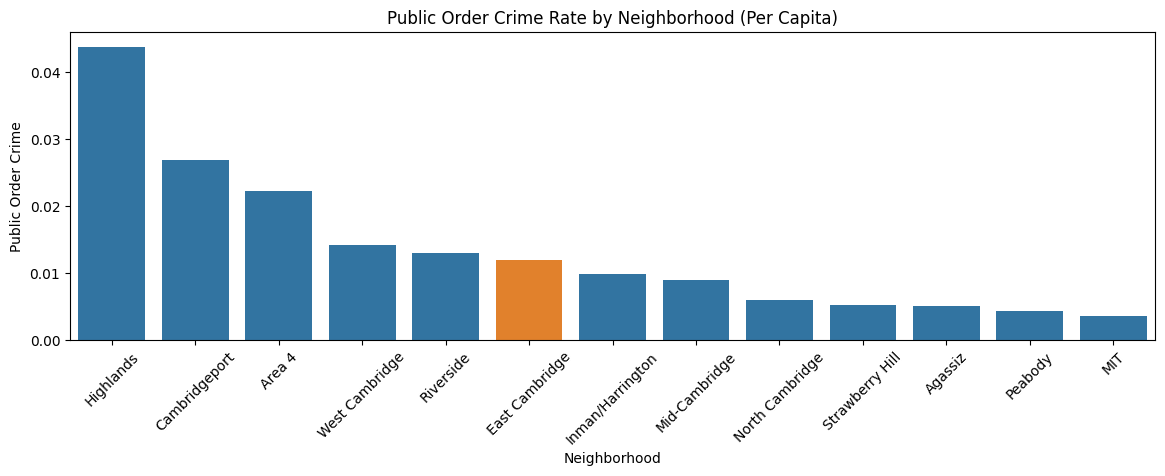

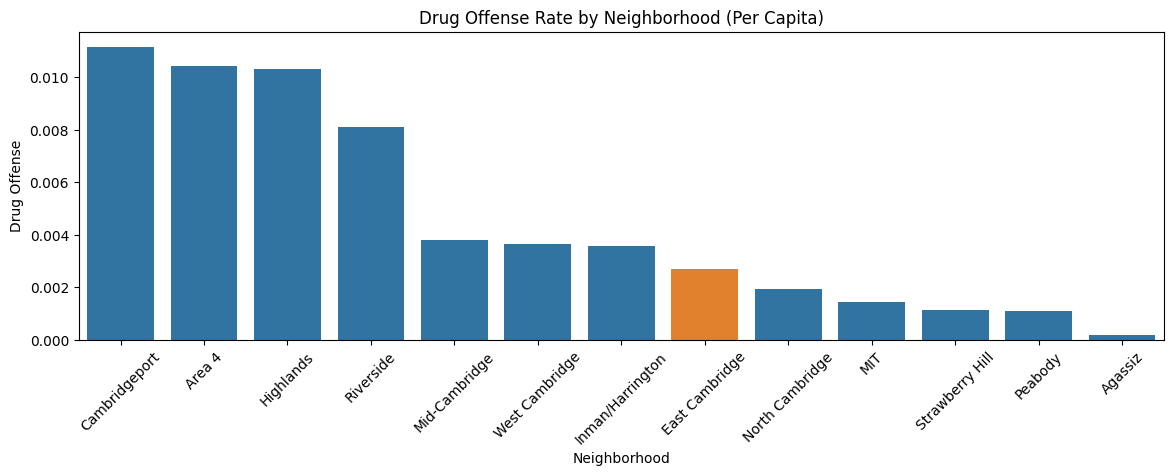

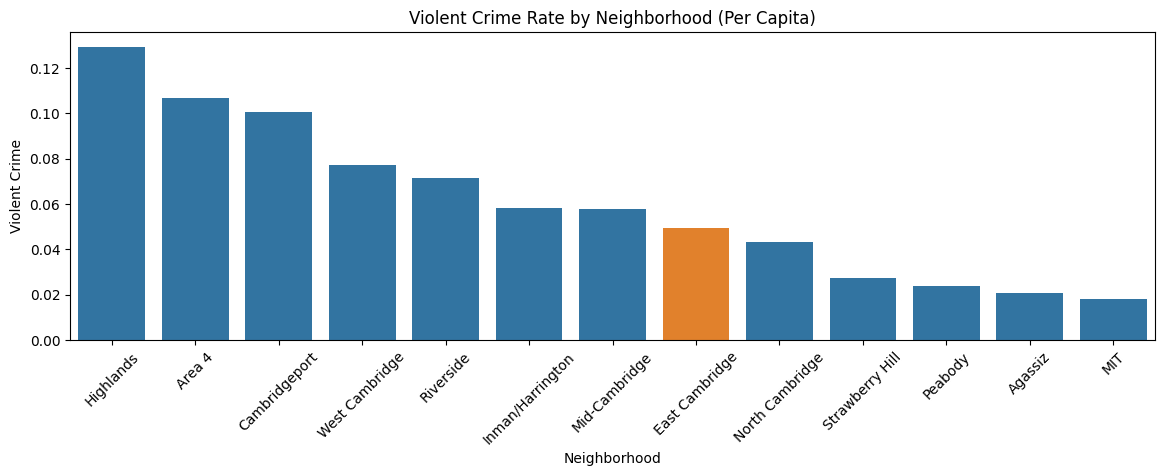

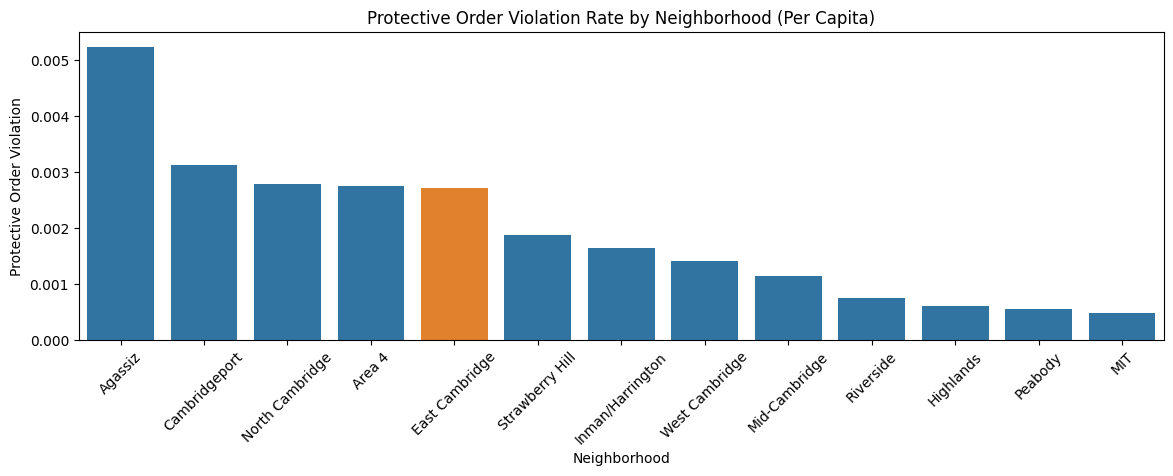

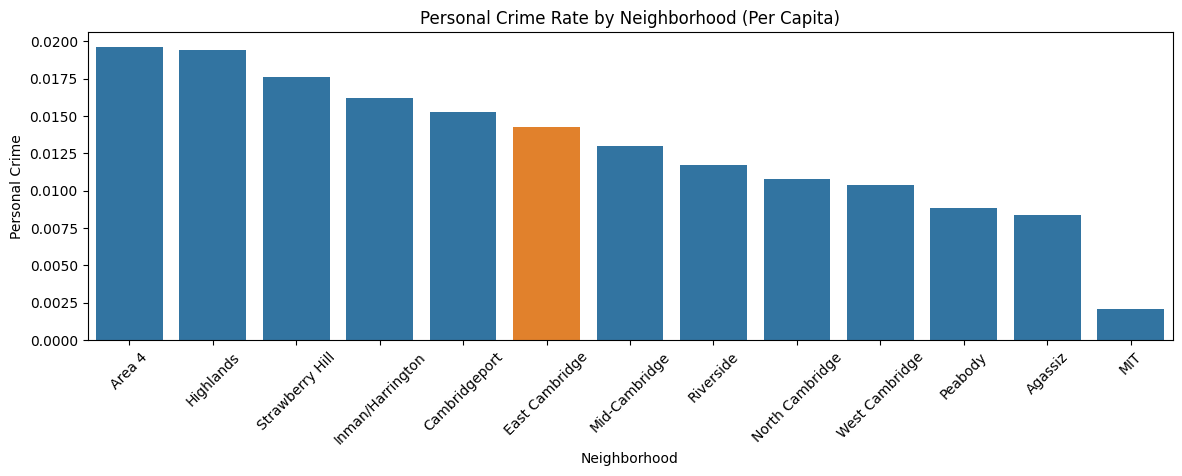

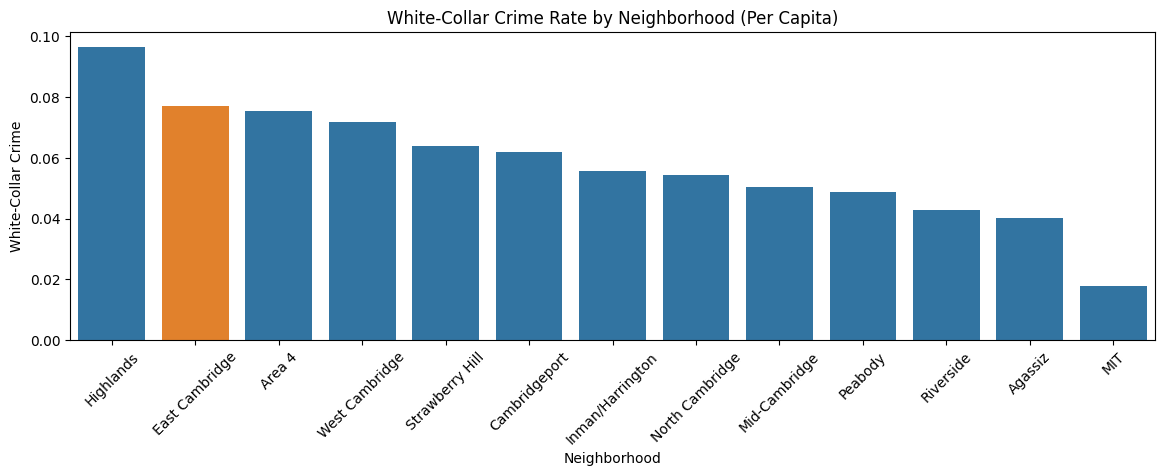

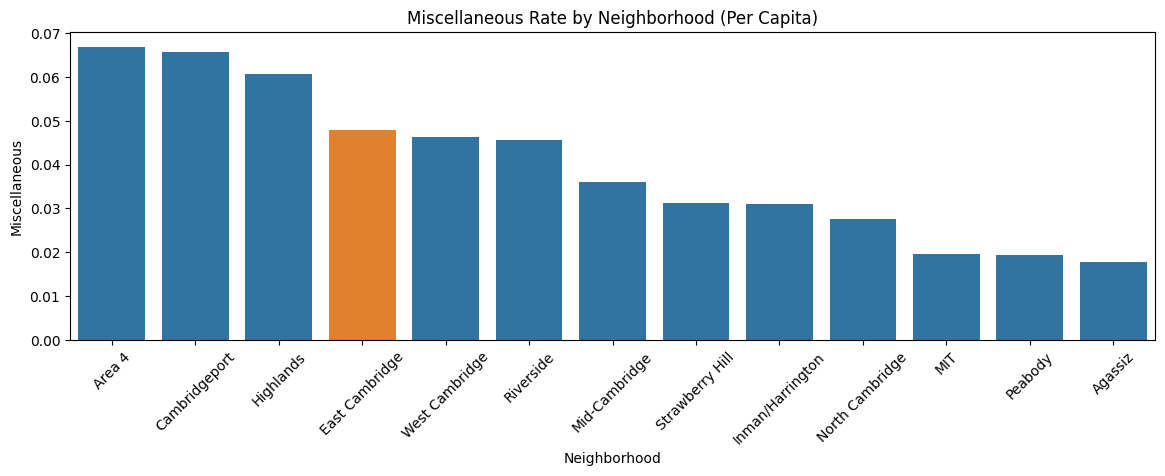

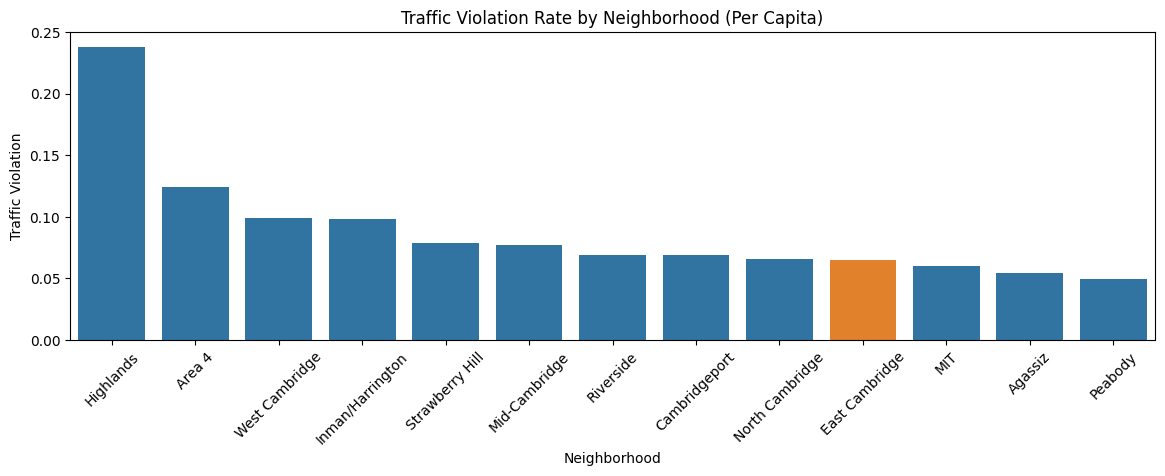

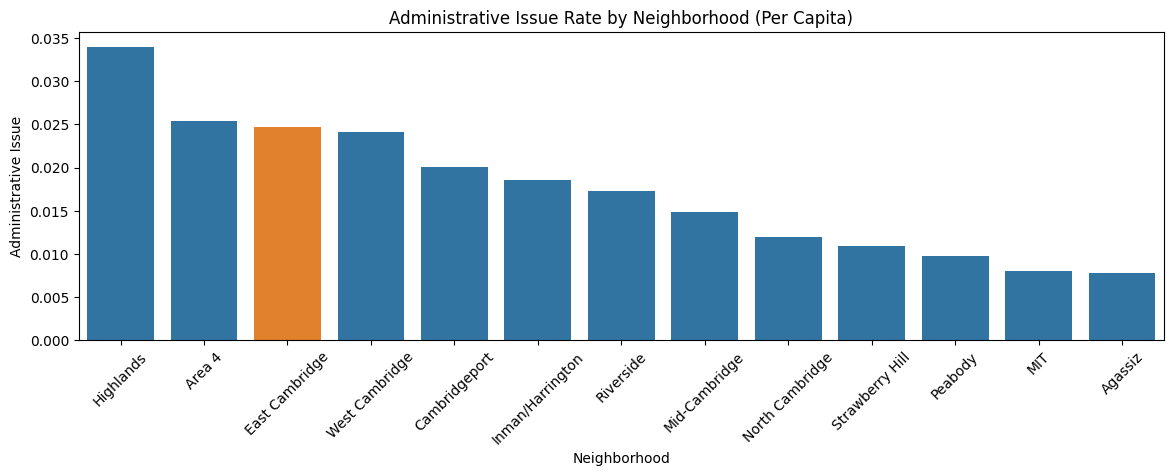

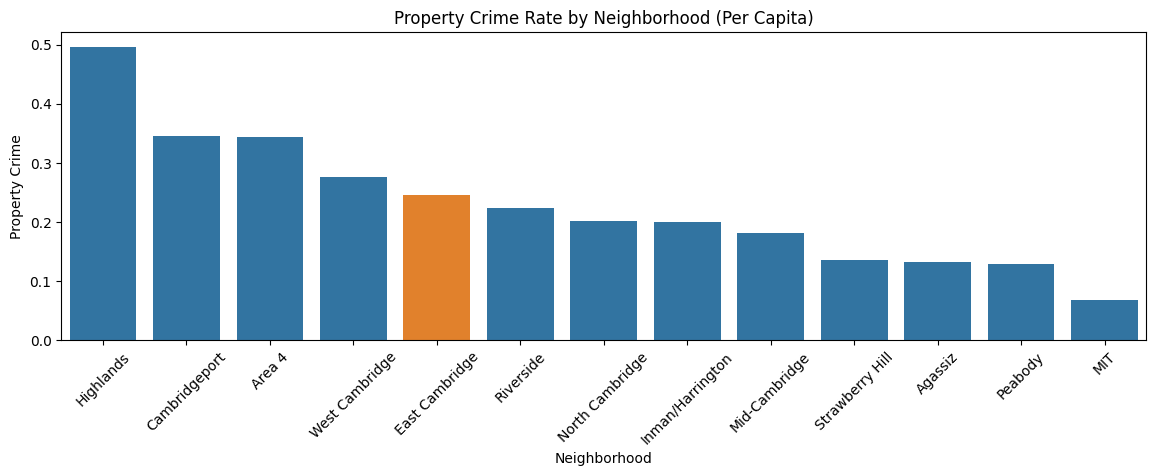

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

macro_crime_categories = set(crime_macro_categories.values())
colors = sns.color_palette('tab10', n_colors=2)
neighborhoods_colors = {neigh: colors[0] for neigh in rel_crime_table_macro.index}
neighborhoods_colors['East Cambridge'] = colors[1]

for category in macro_crime_categories:
    plt.figure(figsize=(14, 4))
    sorted_df = pd.DataFrame(rel_crime_table_macro[category].sort_values(ascending=False))
    sns.barplot(data=sorted_df, x='Neighborhood', hue='Neighborhood', y=category, palette=neighborhoods_colors)
    plt.title(f'{category} Rate by Neighborhood (Per Capita)')
    plt.xticks(rotation=45)
    plt.show()

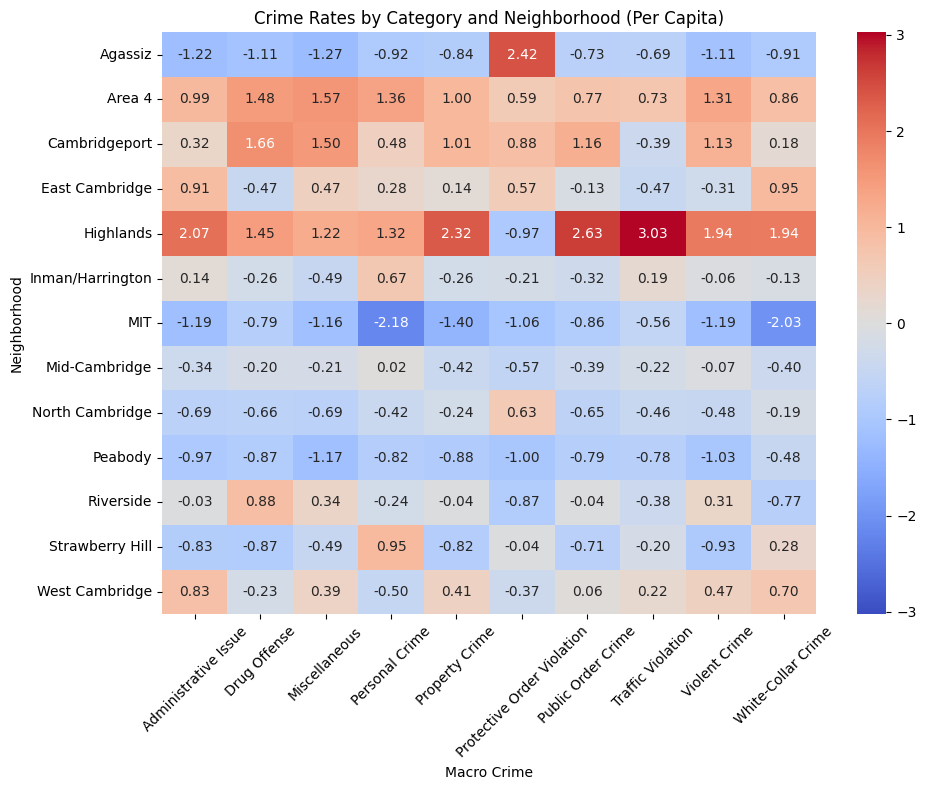

In [14]:
norm_crime_table_macro = (rel_crime_table_macro - rel_crime_table_macro.mean()) / rel_crime_table_macro.std()

vmin = -max(abs(norm_crime_table_macro.min().min()), abs(norm_crime_table_macro.max().max()))
vmax = -vmin

plt.figure(figsize=(10, 8))
sns.heatmap(data=norm_crime_table_macro, annot=True, fmt=".2f", cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.title('Crime Rates by Category and Neighborhood (Per Capita)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
import geopandas as gpd
import folium
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

# Load the shapefile using Geopandas
shapefile_path = 'C:\\Users\\nicco\\OneDrive\\Documents\\Github\\1. Pjts\\3. Cambridge Crime\\BOUNDARY_CDDNeighborhoods.shp'
geo_df = gpd.read_file(shapefile_path)

# Reproject to WGS84 (required for Folium maps)
if geo_df.crs != "EPSG:4326":
    geo_df = geo_df.to_crs(epsg=4326)

# Create a mapping dictionary to align neighborhood names
name_mapping = {
    "The Port": "Area 4",
    "Neighborhood Nine": "Peabody",
    "Wellington-Harrington": "Inman/Harrington",
    "Mid-Cambridge": "Mid-Cambridge",
    "North Cambridge": "North Cambridge",
    "Cambridge Highlands": "Highlands",
    "Strawberry Hill": "Strawberry Hill",
    "West Cambridge": "West Cambridge",
    "Riverside": "Riverside",
    "Cambridgeport": "Cambridgeport",
    "Area 2/MIT": "MIT",
    "East Cambridge": "East Cambridge",
    "Baldwin": "Agassiz",
}

# Map `geo_df['NAME']` to match `rel_crime_table_macro.index`
geo_df['Mapped_Name'] = geo_df['NAME'].map(name_mapping)

# Function to render the map based on selected macro crime
def render_map(selected_macro):
    clear_output(wait=True)  # Clear previous output to avoid duplicates

    # Create a DataFrame from the population dictionary
    pop_df = pd.DataFrame.from_dict(neighborhoods_pop_2020, orient='index', columns=['Population'])
    pop_df.index.name = 'Neighborhood'
    pop_df = pop_df.reset_index()

    # Merge the selected crime data and population into GeoDataFrame
    geo_df_selected = geo_df.merge(
        rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
    )
    geo_df_selected = geo_df_selected.merge(
        pop_df, how='left', left_on='Mapped_Name', right_on='Neighborhood'
    )
    geo_df_selected[selected_macro] = geo_df_selected[selected_macro].round(5)

    # Convert to GeoJSON
    geo_json = geo_df_selected.to_json()

    # Calculate the map's center
    center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()

    # Create a Folium map
    m = folium.Map(location=center_coords, zoom_start=13.5)

    # Add the selected choropleth layer
    folium.Choropleth(
        geo_data=geo_json,
        data=geo_df_selected,
        columns=['Mapped_Name', selected_macro],
        key_on='feature.properties.Mapped_Name',
        fill_color='YlOrRd',
        fill_opacity=0.65,
        line_opacity=0.4,
        legend_name=f'Relative {selected_macro} Rate',
    ).add_to(m)

    # Add GeoJSON layer with click events
    style_function = lambda x: {'fillColor': 'transparent', 'color': 'transparent'}
    highlight_function = lambda x: {'fillColor': 'transparent', 'color': 'transparent'}
    
    folium.GeoJson(
        geo_json,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['Mapped_Name', selected_macro, 'Population'],
            aliases=['Neighborhood:', f'{selected_macro} Score:', 'Population:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)
    
    # Display the map
    display(crime_dropdown)  # Show dropdown again
    display(m)

In [81]:
# Dropdown menu for selecting crime category
crime_dropdown = widgets.Dropdown(
    options=rel_crime_table_macro.columns.tolist(),
    value='Violent Crime',  # Default selection
    description='Crime:',
)

# Link the dropdown to the render_map function
crime_dropdown.observe(lambda change: render_map(crime_dropdown.value), names='value')

# Initial rendering
render_map(crime_dropdown.value)

C:\Users\nicco\AppData\Local\Temp\ipykernel_108008\2829545516.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()


Dropdown(description='Crime:', index=6, options=('Administrative Issue', 'Drug Offense', 'Miscellaneous', 'Per…

In [11]:
#### MAP WITH BOTH BOSTON AND CAMBRIDGE BUT SEPARATED


# import pandas as pd
# import numpy as np
# import geopandas as gpd
# import folium
# from IPython.display import display, clear_output
# import ipywidgets as widgets

# # Keep all your existing data loading and preprocessing code here, up until the widgets...

# # Create unified widgets
# municipality_dropdown = widgets.Dropdown(
#     options=['Cambridge', 'Boston'],
#     value='Cambridge',
#     description='City:',
#     style={'description_width': 'initial'}
# )

# crime_dropdown = widgets.Dropdown(
#     options=sorted(neighborhoods_crime_cambridge['Macro Crime'].unique()),
#     value='Violent Crime',
#     description='Crime:',
#     style={'description_width': 'initial'}
# )

# start_date_picker = widgets.DatePicker(
#     description='Start Date:',
#     value=pd.to_datetime('2015-01-01'),
#     style={'description_width': 'initial'}
# )

# end_date_picker = widgets.DatePicker(
#     description='End Date:',
#     value=pd.to_datetime('2025-01-07'),
#     style={'description_width': 'initial'}
# )

# controls = widgets.HBox([municipality_dropdown, crime_dropdown, start_date_picker, end_date_picker])

# def render_map(selected_municipality=None, selected_macro=None, start_date=None, end_date=None):
#     clear_output(wait=True)
    
#     if selected_municipality == 'Cambridge':
#         crime_data = neighborhoods_crime_cambridge
#         geo_df = geo_df_cambridge
#         pop_data = neighborhoods_pop_2020_cambridge
#         date_col = 'Date'
#         zoom_start = 13
#         pop_year = '2020'
#     else:  # Boston
#         crime_data = neighborhoods_crime_boston
#         geo_df = geo_df_boston
#         pop_data = neighborhoods_pop_2019_boston
#         date_col = 'Date'
#         zoom_start = 12
#         pop_year = '2019'
    
#     # Filter data by date
#     filtered_crime = crime_data[
#         (crime_data[date_col] >= pd.to_datetime(start_date)) & 
#         (crime_data[date_col] <= pd.to_datetime(end_date))
#     ].copy()
    
#     # Calculate crime rates
#     if selected_municipality == 'Cambridge':
#         crime_table_macro = filtered_crime.groupby(['Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
#         rel_crime_table_macro = crime_table_macro.div(pd.Series(pop_data), axis=0)
#     else:
#         crime_table_macro = filtered_crime.groupby(['Mapped_Neighborhood', 'Macro Crime']).size().unstack('Macro Crime').fillna(0)
#         rel_crime_table_macro = crime_table_macro.div(pd.Series(pop_data), axis=0)
    
#     # Create population DataFrame
#     pop_df = pd.DataFrame.from_dict(pop_data, orient='index', columns=['Population'])
#     pop_df.index.name = 'Neighborhood'
#     pop_df = pop_df.reset_index()

#     # Merge data
#     if selected_municipality == 'Cambridge':
#         geo_df_selected = geo_df.merge(
#             rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
#         )
#     else:
#         geo_df_selected = geo_df.merge(
#             rel_crime_table_macro[[selected_macro]], how='left', left_on='Mapped_Name', right_index=True
#         )
    
#     geo_df_selected = geo_df_selected.merge(
#         pop_df, how='left', left_on='Mapped_Name', right_on='Neighborhood'
#     )
#     geo_df_selected[selected_macro] = geo_df_selected[selected_macro].round(5)

#     # Create map
#     geo_json = geo_df_selected.to_json()
#     center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()
#     m = folium.Map(location=center_coords, zoom_start=zoom_start)
    
#     # Add choropleth layer
#     folium.Choropleth(
#         geo_data=geo_json,
#         data=geo_df_selected,
#         columns=['Mapped_Name', selected_macro],
#         key_on='feature.properties.Mapped_Name',
#         fill_color='YlOrRd',
#         fill_opacity=0.65,
#         line_opacity=0.4,
#         legend_name=f'Relative {selected_macro} Rate',
#     ).add_to(m)

#     # Add tooltip layer
#     folium.GeoJson(
#         geo_json,
#         style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
#         tooltip=folium.GeoJsonTooltip(
#             fields=['Mapped_Name', selected_macro, 'Population'],
#             aliases=['Neighborhood:', f'{selected_macro} Score:', f'Population ({pop_year}):'],
#             style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
#         )
#     ).add_to(m)
    
#     display(controls)
#     display(m)

# def update_crime_categories(*args):
#     if municipality_dropdown.value == 'Cambridge':
#         crime_dropdown.options = sorted(neighborhoods_crime_cambridge['Macro Crime'].unique())
#     else:
#         crime_dropdown.options = sorted(neighborhoods_crime_boston['Macro Crime'].unique())

# def update_map(change=None):
#     render_map(
#         selected_municipality=municipality_dropdown.value,
#         selected_macro=crime_dropdown.value,
#         start_date=start_date_picker.value,
#         end_date=end_date_picker.value
#     )

# # Link widgets to update functions
# municipality_dropdown.observe(lambda change: update_crime_categories(), names='value')
# municipality_dropdown.observe(lambda change: update_map(), names='value')
# crime_dropdown.observe(lambda change: update_map(), names='value')
# start_date_picker.observe(lambda change: update_map(), names='value')
# end_date_picker.observe(lambda change: update_map(), names='value')

# # Initial rendering
# update_map()

C:\Users\nicco\AppData\Local\Temp\ipykernel_32832\2403819799.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_coords = geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()
